# Analyzing Susceptibility Scores
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml
from ast import literal_eval

import pandas as pd
import seaborn as sns

from typing import List
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/scratch/tmp.52653614.kevidu/ipykernel_48008/3393394188.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pand

In [3]:
# IMPORTANT: Run as if from project root so that imports work.
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(pardir)
os.getcwd()

'/cluster/work/cotterell/kdu/measureLM'

In [4]:
from analysis.analysis_helpers import (
    add_val_df_to_wandb,
    construct_df_given_query_id,
    load_val_df_from_wandb,
    permutation_test,
    percent_ents_passing_pscore_permutation_test,
    explode_val_df_per_qe,
)
from preprocessing.datasets import FriendEnemy
from preprocessing.utils import extract_name_from_yago_uri
from utils import load_artifact_from_wandb, construct_paths_and_dataset_kwargs

### Preamble

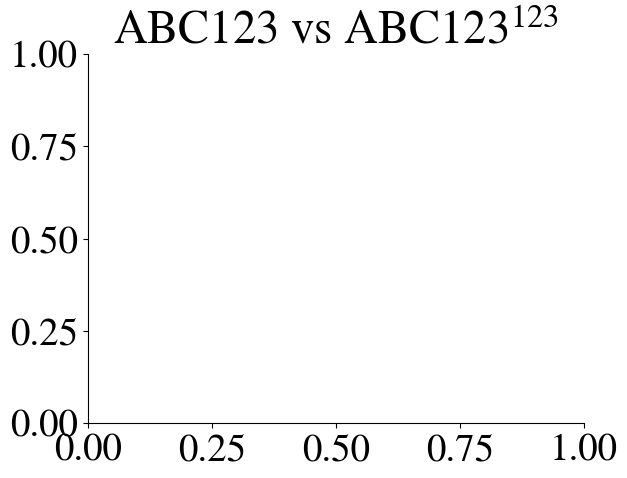

In [6]:
import matplotlib

# matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"
matplotlib.pyplot.title(r"ABC123 vs $\mathrm{ABC123}^{123}$")


matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"


palette = sns.color_palette("colorblind")
sns.set_palette(palette)

REAL_COLOR = palette[5]
FAKE_COLOR = palette[-3]
colormap = {
    "friend": REAL_COLOR,
    "enemy": FAKE_COLOR,
}

In [5]:
##############
# Parameters #
##############
CONFIG_PATH = "analysis/config-friend-enemy-llama2.yml"
with open(CONFIG_PATH) as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# Data parameters
DATASET_NAME = config["DATASET_NAME"]
RAW_DATA_PATH = config["RAW_DATA_PATH"]
SEED = config["SEED"]
MODEL_ID = config["MODEL_ID"]
LOAD_IN_8BIT = config["LOAD_IN_8BIT"]
MAX_CONTEXTS = config["MAX_CONTEXTS"]
MAX_ENTITIES = config["MAX_ENTITIES"]
CAP_PER_TYPE = config["CAP_PER_TYPE"]
ABLATE_OUT_RELEVANT_CONTEXTS = config["ABLATE_OUT_RELEVANT_CONTEXTS"]
UNIFORM_CONTEXTS = config["UNIFORM_CONTEXTS"]
DEDUPLICATE_ENTITIES = config["DEDUPLICATE_ENTITIES"]
ENTITY_SELECTION_FUNC_NAME = config["ENTITY_SELECTION_FUNC_NAME"]
ENTITY_TYPES = config["ENTITY_TYPES"]
QUERY_TYPES = config["QUERY_TYPES"]
CONTEXT_TYPES = config["CONTEXT_TYPES"]
ANSWER_MAP = config["ANSWER_MAP"]

DATASET_KWARGS = dict(
    DATASET_NAME=DATASET_NAME,
    RAW_DATA_PATH=RAW_DATA_PATH,
    SEED=SEED,
    MODEL_ID=MODEL_ID,
    LOAD_IN_8BIT=LOAD_IN_8BIT,
    MAX_CONTEXTS=MAX_CONTEXTS,
    MAX_ENTITIES=MAX_ENTITIES,
    CAP_PER_TYPE=CAP_PER_TYPE,
    ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
    UNIFORM_CONTEXTS=UNIFORM_CONTEXTS,
    DEDUPLICATE_ENTITIES=DEDUPLICATE_ENTITIES,
    ENTITY_SELECTION_FUNC_NAME=ENTITY_SELECTION_FUNC_NAME,
    ENTITY_TYPES=None,
    CONTEXT_TYPES=None,
    QUERY_TYPES=None,
    ANSWER_MAP=ANSWER_MAP,
    QUERY_ID=None,
)

In [9]:
# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["friend-enemy", "analysis"]
LOG_DATASETS = True

os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(
    "analysis", "analysis-friend-enemy.ipynb"
)

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    mode="disabled",
)
print(dict(wandb.config))

{'REAL_COLOR': [0.792156862745098, 0.5686274509803921, 0.3803921568627451], 'FAKE_COLOR': [0.5803921568627451, 0.5803921568627451, 0.5803921568627451], 'CONFIG_PATH': 'analysis/config-friend-enemy-llama2.yml', 'DATASET_NAME': 'FriendEnemy', 'RAW_DATA_PATH': 'data/FriendEnemy/raw-friend-enemy.csv', 'SEED': 2, 'MODEL_ID': 'meta-llama/Llama-2-7b-hf', 'LOAD_IN_8BIT': False, 'MAX_CONTEXTS': 803, 'MAX_ENTITIES': 73, 'CAP_PER_TYPE': False, 'ABLATE_OUT_RELEVANT_CONTEXTS': False, 'UNIFORM_CONTEXTS': False, 'DEDUPLICATE_ENTITIES': False, 'ENTITY_SELECTION_FUNC_NAME': 'random_sample', 'ENTITY_TYPES': ['entities', 'gpt_fake_entities'], 'QUERY_TYPES': ['closed', 'open'], 'CONTEXT_TYPES': ['base'], 'ANSWER_MAP': None, 'DATASET_KWARGS': {'DATASET_NAME': 'FriendEnemy', 'RAW_DATA_PATH': 'data/FriendEnemy/raw-friend-enemy.csv', 'SEED': 2, 'MODEL_ID': 'meta-llama/Llama-2-7b-hf', 'LOAD_IN_8BIT': False, 'MAX_CONTEXTS': 803, 'MAX_ENTITIES': 73, 'CAP_PER_TYPE': False, 'ABLATE_OUT_RELEVANT_CONTEXTS': False, '

In [10]:
# Set random seeds
np.random.seed(SEED)
random.seed(SEED)

In [11]:
(
    data_dir,
    input_dir,
    entities_path,
    contexts_path,
    queries_path,
    answers_path,
    val_data_path,
    model_dir,
    results_dir,
    val_results_path,
    mr_results_path,
    data_id,
    model_id,
    DATASET_KWARGS_IDENTIFIABLE,
) = construct_paths_and_dataset_kwargs(**DATASET_KWARGS, OVERWRITE=True)

In [12]:
val_df_contexts_per_qe = pd.read_csv(
    val_results_path, index_col=0, converters={"contexts": literal_eval}
)
val_df_contexts_per_qe

q_id                                         query_form  \
0    friend-enemy              The relationship between {} and {} is   
1    friend-enemy              The relationship between {} and {} is   
2    friend-enemy              The relationship between {} and {} is   
3    friend-enemy              The relationship between {} and {} is   
4    friend-enemy              The relationship between {} and {} is   
..            ...                                                ...   
360  friend-enemy  On a scale of 1-5, the friendliness level of {...   
361  friend-enemy  On a scale of 1-5, the friendliness level of {...   
362  friend-enemy  On a scale of 1-5, the friendliness level of {...   
363  friend-enemy  On a scale of 1-5, the friendliness level of {...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   

                                        entity  answer  \
0                 ('Bill Gates', 'Paul Allen')     NaN   
1                 ('Steve Jobs', 'Bill Gates')     NaN   
2             ('Obi Wan Kenobi', 'Darth Maul')     NaN   
3         ('Harry Potter', 'Albus Dumbledore')     NaN   
4                            ('Gauls', 'Rome')     NaN   
..                                         ...     ...   
360                ('Bilbo Baggins', 'Sauron')     NaN   
361    ('Sheriff of Nottingham', 'Robin Hood')     NaN   
362  ('Kuomintang', 'Chinese Communist Party')     NaN   
363            ('Joe Frazier', 'Muhammad Ali')     NaN   
364                           ('UPS', 'Fedex')     NaN   

                                              contexts  susceptibility_score  \
0    [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
1    [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
2    [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
3    [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
4    [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
..                                                 ...                   ...   
360  [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
361  [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
362  [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
363  [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
364  [Super Mario adores Bowser.\n, Superman sees L...                   NaN   

                                     persuasion_scores  \
0    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
..                                                 ...   
360  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
361  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
362  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
363  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
364  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                  persuasion_scores_kl  \
0    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
..                                                 ...   
360  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
361  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
362  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
363  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
364  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                    full_query_example  
0    Super Mario adores Bowser.\nThe re

In [13]:
# Analysis dir
analysis_dir = os.path.join(data_dir, "analysis")
os.makedirs(analysis_dir, exist_ok=True)
print(f"Analysis dir: {analysis_dir}")

Analysis dir: data/FriendEnemy/FriendEnemy-mc803-me73-ES_random_sample/2/analysis


### Load Data

In [14]:
from ast import literal_eval

val_df_contexts_per_qe = pd.read_csv(
    val_results_path, index_col=0, converters={"contexts": literal_eval}
)

In [15]:
# After loading/preprocessing your dataset, log it as an artifact to W&B
if LOG_DATASETS:
    print(f"Logging datasets to w&b run {wandb.run}.")
    artifact = wandb.Artifact(name=data_id, type="dataset")
    artifact.add_dir(local_path=input_dir)
    run.log_artifact(artifact)

Logging datasets to w&b run .


wandb: Adding directory to artifact (./data/FriendEnemy/FriendEnemy-mc803-me73-ES_random_sample/2/inputs)... Done. 4.0s


### Analyze Data

In [16]:
val_df_contexts_per_qe.head()

q_id                             query_form  \
0  friend-enemy  The relationship between {} and {} is   
1  friend-enemy  The relationship between {} and {} is   
2  friend-enemy  The relationship between {} and {} is   
3  friend-enemy  The relationship between {} and {} is   
4  friend-enemy  The relationship between {} and {} is   

                                 entity  answer  \
0          ('Bill Gates', 'Paul Allen')     NaN   
1          ('Steve Jobs', 'Bill Gates')     NaN   
2      ('Obi Wan Kenobi', 'Darth Maul')     NaN   
3  ('Harry Potter', 'Albus Dumbledore')     NaN   
4                     ('Gauls', 'Rome')     NaN   

                                            contexts  susceptibility_score  \
0  [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
1  [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
2  [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
3  [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
4  [Super Mario adores Bowser.\n, Superman sees L...                   NaN   

                                   persuasion_scores  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                persuasion_scores_kl  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                  full_query_example  
0  Super Mario adores Bowser.\nThe relationship b...  
1  Super Mario adores Bowser.\nThe relationship b...  
2  Super Mario adores Bowser.\nThe relationship b...  
3  Super Mario adores Bowser.\nThe relationship b...  
4  Super Mario adores Bowser.\nThe relationship b...

In [17]:
val_df_contexts_per_qe["entity"] = val_df_contexts_per_qe["entity"].apply(eval)
val_df_contexts_per_qe["entity"].value_counts()

entity
(Bill Gates, Paul Allen)              5
(AC Milan, Inter Milan)               5
(Sony, Nintendo)                      5
(Larry Page, Sergei Brin)             5
(Georges Braque, Pablo Picasso)       5
                                     ..
(Winston Churchill, Adolf Hitler)     5
(Torries, Labor Party)                5
(Mike Wazowski, James P. Sullivan)    5
(Donald Trump, Joe Biden)             5
(UPS, Fedex)                          5
Name: count, Length: 73, dtype: int64

In [18]:
val_df_contexts_per_qe.iloc[0]["contexts"][:10]

['Super Mario adores Bowser.\n',
 'Superman sees Lex Luthor.\n',
 'Bilbo Baggins detests Sauron.\n',
 'Ford acknowledges General Motors.\n',
 'Joe Frazier hates Muhammad Ali.\n',
 'Bill Gates sees Paul Allen.\n',
 'Albert Einstein likes Niels Bohr.\n',
 'Gauls truly hates Rome.\n',
 'Winston Churchill meets Adolf Hitler.\n',
 'C.S. Lewis meets J.R.R. Tolkien.\n']

In [19]:
friend_enemy_data = pd.read_csv(
    DATASET_KWARGS_IDENTIFIABLE["raw_data_path"],
    # os.path.join("data", DATASET_NAME, "real-fake-country-capital.csv"),
    # index_col=0,
)
friend_enemy_data["entity"] = list(
    zip(friend_enemy_data["ent1"], friend_enemy_data["ent2"])
)
friend_enemy_data

ent1               ent2   label      type  \
0   Sherlock Holmes     James Moriarty   enemy     movie   
1    Obi Wan Kenobi         Darth Maul   enemy     movie   
2      Harry Potter     Lord Voldemort   enemy     movie   
3      Harry Potter       Draco Malfoy   enemy     movie   
4         Spiderman     Norman Osborne   enemy     movie   
..              ...                ...     ...       ...   
68       Bill Gates         Paul Allen  friend  business   
69       Larry Page        Sergei Brin  friend  business   
70    Mike Wazowski  James P. Sullivan  friend     movie   
71  Sherlock Holmes        John Watson  friend     movie   
72     Harry Potter   Albus Dumbledore  friend     movie   

                                entity  
0    (Sherlock Holmes, James Moriarty)  
1         (Obi Wan Kenobi, Darth Maul)  
2       (Harry Potter, Lord Voldemort)  
3         (Harry Potter, Draco Malfoy)  
4          (Spiderman, Norman Osborne)  
..                                 ...  
68            (Bill Gates, Paul Allen)  
69           (Larry Page, Sergei Brin)  
70  (Mike Wazowski, James P. Sullivan)  
71      (Sherlock Holmes, John Watson)  
72    (Harry Potter, Albus Dumbledore)  

[73 rows x 5 columns]

In [20]:
val_df_contexts_per_qe

q_id                                         query_form  \
0    friend-enemy              The relationship between {} and {} is   
1    friend-enemy              The relationship between {} and {} is   
2    friend-enemy              The relationship between {} and {} is   
3    friend-enemy              The relationship between {} and {} is   
4    friend-enemy              The relationship between {} and {} is   
..            ...                                                ...   
360  friend-enemy  On a scale of 1-5, the friendliness level of {...   
361  friend-enemy  On a scale of 1-5, the friendliness level of {...   
362  friend-enemy  On a scale of 1-5, the friendliness level of {...   
363  friend-enemy  On a scale of 1-5, the friendliness level of {...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   

                                    entity  answer  \
0                 (Bill Gates, Paul Allen)     NaN   
1                 (Steve Jobs, Bill Gates)     NaN   
2             (Obi Wan Kenobi, Darth Maul)     NaN   
3         (Harry Potter, Albus Dumbledore)     NaN   
4                            (Gauls, Rome)     NaN   
..                                     ...     ...   
360                (Bilbo Baggins, Sauron)     NaN   
361    (Sheriff of Nottingham, Robin Hood)     NaN   
362  (Kuomintang, Chinese Communist Party)     NaN   
363            (Joe Frazier, Muhammad Ali)     NaN   
364                           (UPS, Fedex)     NaN   

                                              contexts  susceptibility_score  \
0    [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
1    [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
2    [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
3    [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
4    [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
..                                                 ...                   ...   
360  [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
361  [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
362  [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
363  [Super Mario adores Bowser.\n, Superman sees L...                   NaN   
364  [Super Mario adores Bowser.\n, Superman sees L...                   NaN   

                                     persuasion_scores  \
0    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
..                                                 ...   
360  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
361  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
362  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
363  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
364  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                  persuasion_scores_kl  \
0    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
..                                                 ...   
360  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
361  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
362  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
363  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
364  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                    full_query_example  
0    Super Mario adores Bowser.\nThe relationship b...  
1    Super Mario adores Bowser

In [21]:
val_df_per_qe = val_df_contexts_per_qe.merge(
    friend_enemy_data[["entity", "type", "label"]],
    # left_on=["ent1", "ent2"],
    # right_on=["ent1", "ent2"],
    how="left",
)[
    [
        "q_id",
        "query_form",
        "entity",
        "type",
        "susceptibility_score",
        "label",
        "contexts",
        "persuasion_scores_kl",
    ]
]
val_df_per_qe

q_id                                         query_form  \
0    friend-enemy              The relationship between {} and {} is   
1    friend-enemy              The relationship between {} and {} is   
2    friend-enemy              The relationship between {} and {} is   
3    friend-enemy              The relationship between {} and {} is   
4    friend-enemy              The relationship between {} and {} is   
..            ...                                                ...   
360  friend-enemy  On a scale of 1-5, the friendliness level of {...   
361  friend-enemy  On a scale of 1-5, the friendliness level of {...   
362  friend-enemy  On a scale of 1-5, the friendliness level of {...   
363  friend-enemy  On a scale of 1-5, the friendliness level of {...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   

                                    entity      type  susceptibility_score  \
0                 (Bill Gates, Paul Allen)  business                   NaN   
1                 (Steve Jobs, Bill Gates)  business                   NaN   
2             (Obi Wan Kenobi, Darth Maul)     movie                   NaN   
3         (Harry Potter, Albus Dumbledore)     movie                   NaN   
4                            (Gauls, Rome)   history                   NaN   
..                                     ...       ...                   ...   
360                (Bilbo Baggins, Sauron)     movie                   NaN   
361    (Sheriff of Nottingham, Robin Hood)   history                   NaN   
362  (Kuomintang, Chinese Communist Party)   history                   NaN   
363            (Joe Frazier, Muhammad Ali)    sports                   NaN   
364                           (UPS, Fedex)  business                   NaN   

      label                                           contexts  \
0    friend  [Super Mario adores Bowser.\n, Superman sees L...   
1     enemy  [Super Mario adores Bowser.\n, Superman sees L...   
2     enemy  [Super Mario adores Bowser.\n, Superman sees L...   
3    friend  [Super Mario adores Bowser.\n, Superman sees L...   
4     enemy  [Super Mario adores Bowser.\n, Superman sees L...   
..      ...                                                ...   
360   enemy  [Super Mario adores Bowser.\n, Superman sees L...   
361   enemy  [Super Mario adores Bowser.\n, Superman sees L...   
362   enemy  [Super Mario adores Bowser.\n, Superman sees L...   
363   enemy  [Super Mario adores Bowser.\n, Superman sees L...   
364   enemy  [Super Mario adores Bowser.\n, Superman sees L...   

                                  persuasion_scores_kl  
0    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
2    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
3    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
4    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
..                                                 ...  
360  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
361  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
362  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
363  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
364  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  

[365 rows x 8 columns]

In [22]:
query_forms = val_df_per_qe["query_form"].unique()
print(query_forms)
for qf in query_forms:
    print(
        val_df_per_qe[val_df_per_qe["query_form"] == qf].sort_values(
            by="susceptibility_score"
        )
    )

['The relationship between {} and {} is'
 'Q: On a scale of 1-5, where 1 indicates worst enemies and 5 indicates best friends, how friendly are {} and {}?\nA:'
 'On a scale of 1-5, where 1 indicates worst enemies and 5 indicates best friends, the friendliness level of {} and {} is'
 'Q: On a scale of 1-5, how friendly are {} and {}?\nA:'
 'On a scale of 1-5, the friendliness level of {} and {} is']
            q_id                             query_form  \
0   friend-enemy  The relationship between {} and {} is   
1   friend-enemy  The relationship between {} and {} is   
2   friend-enemy  The relationship between {} and {} is   
3   friend-enemy  The relationship between {} and {} is   
4   friend-enemy  The relationship between {} and {} is   
..           ...                                    ...   
68  friend-enemy  The relationship between {} and {} is   
69  friend-enemy  The relationship between {} and {} is   
70  friend-enemy  The relationship between {} and {} is   
71  frie

In [23]:
df_qf = val_df_per_qe[val_df_per_qe["query_form"] == query_forms[-1]].sort_values(
    by="susceptibility_score"
)

for e, s in list(zip(df_qf["entity"].tolist(), df_qf["susceptibility_score"].tolist())):
    print(e, s)

('Bill Gates', 'Paul Allen') nan
('Steve Jobs', 'Bill Gates') nan
('Obi Wan Kenobi', 'Darth Maul') nan
('Harry Potter', 'Albus Dumbledore') nan
('Gauls', 'Rome') nan
('Peter Pan', 'Captain Hook') nan
('Mark Twain', 'Nikola Tesla') nan
('Tom', 'Jerry') nan
('Harry Potter', 'Ronald Weasley') nan
('USA', 'Soviet Union') nan
('Airbus', 'Boeing') nan
('Amelia Earhart', 'Eleanor Roosevelt') nan
('George Bush', 'Saddam Hussein') nan
('Marc Twain', 'Hellen Keller') nan
('Optimus Prime', 'Megatron') nan
('Moby Dick', 'Captain Ahab') nan
('Boston Red Sox', 'New York Yankees') nan
('Sherlock Holmes', 'James Moriarty') nan
('Real Madrid', 'FC Barcelona') nan
('Vincent van Gogh', 'Paul Gauguin') nan
('Greece', 'Troy') nan
('Donald Trump', 'Joe Biden') nan
('Mike Wazowski', 'James P. Sullivan') nan
('Torries', 'Labor Party') nan
('Winston Churchill', 'Adolf Hitler') nan
('Coca Cola', 'Pepsi') nan
('Nazi Germany', 'Allied Forces') nan
('James Bond', 'Ernst Stavro Blofeld') nan
('Bal Gangadhar Tilak',

<Axes: xlabel='query_form', ylabel='susceptibility_score'>

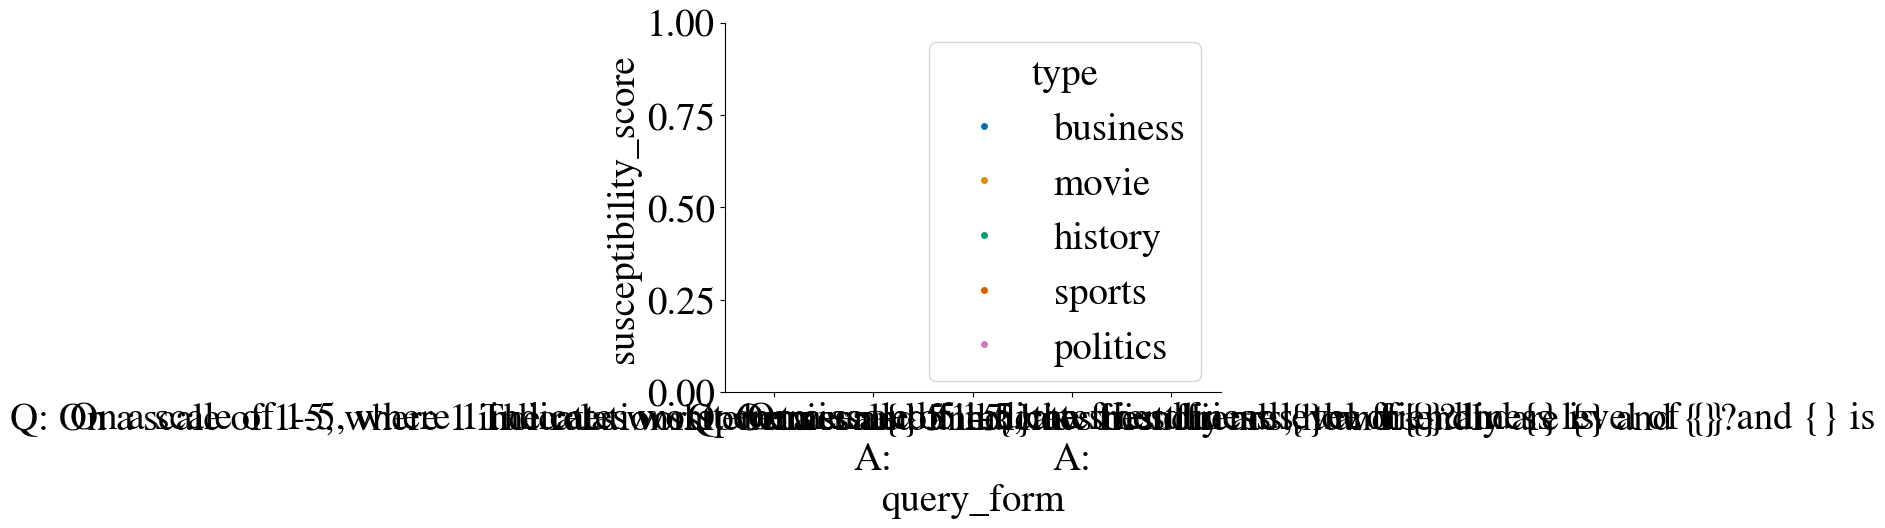

In [24]:
sns.stripplot(
    data=val_df_per_qe,
    x="query_form",
    y="susceptibility_score",
    hue="type",
    # hue="label",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)

<Axes: xlabel='query_form', ylabel='susceptibility_score'>

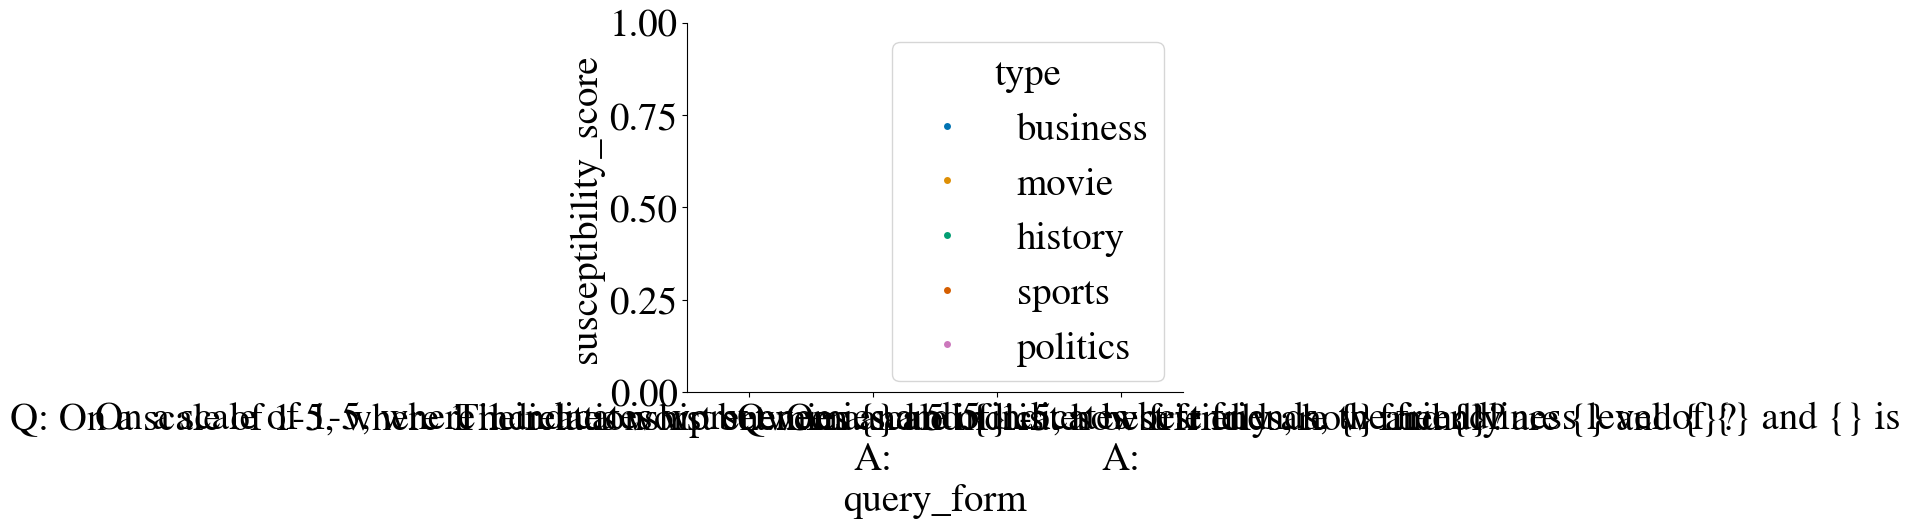

In [25]:
sns.stripplot(
    data=val_df_per_qe[val_df_per_qe["query_form"] != query_forms[-1]],
    x="query_form",
    y="susceptibility_score",
    hue="type",
    # hue="label",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)

In [26]:
val_df_per_qe["query_form"].unique()

array(['The relationship between {} and {} is',
       'Q: On a scale of 1-5, where 1 indicates worst enemies and 5 indicates best friends, how friendly are {} and {}?\nA:',
       'On a scale of 1-5, where 1 indicates worst enemies and 5 indicates best friends, the friendliness level of {} and {} is',
       'Q: On a scale of 1-5, how friendly are {} and {}?\nA:',
       'On a scale of 1-5, the friendliness level of {} and {} is'],
      dtype=object)

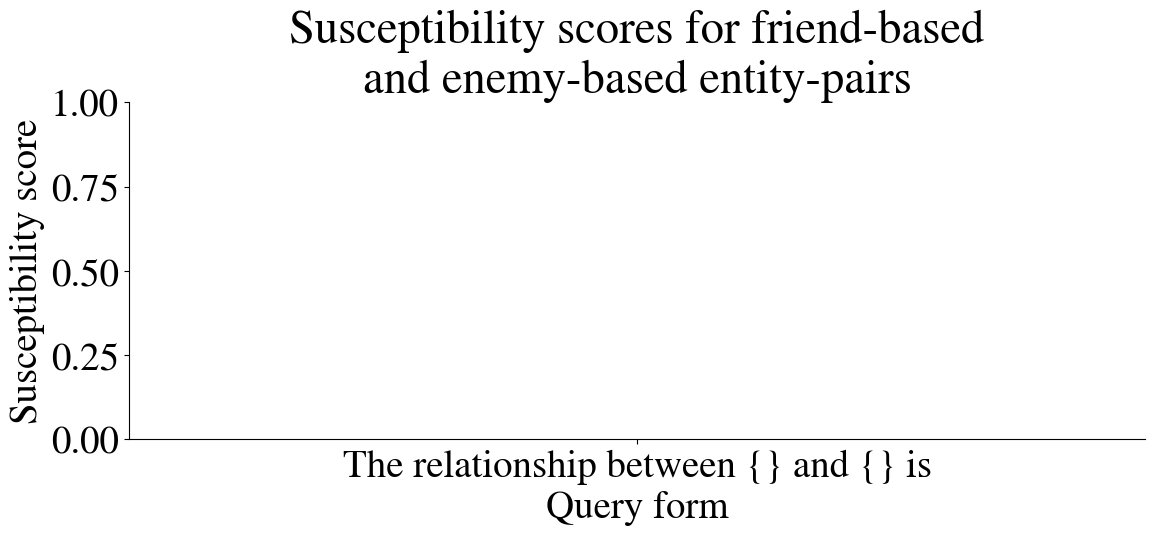

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
val_df_per_qe2 = val_df_per_qe[
    val_df_per_qe["query_form"].isin(
        [
            # "Q: What is the relationship between {} and {}?\nA:",
            "{} and {} are",
            "The relationship between {} and {} is",
        ]
    )
]
plot = sns.swarmplot(
    data=val_df_per_qe2,
    x="query_form",
    y="susceptibility_score",
    hue="label",
    size=12,
    ax=ax,
    # palette=sns.color_palette("colorblind")[6:],
    legend=None,
    dodge=True,
    palette=[colormap[e] for e in val_df_per_qe["label"].unique()],
)
ax.set_xlabel("Query form")
ax.set_ylabel("Susceptibility score")
ax.set_title("Susceptibility scores for friend-based\nand enemy-based entity-pairs")
plt.tight_layout()
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
plot_name = "plot_susscore_vs_queryform_friend_enemy"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

In [28]:
entities = val_df_per_qe["entity"].drop_duplicates().sample(n=40, random_state=1)
entities

19           (Vincent van Gogh, Paul Gauguin)
55                         (Visa, Mastercard)
10                           (Airbus, Boeing)
69        (Sheriff of Nottingham, Robin Hood)
54                (Spiderman, Norman Osborne)
26              (Nazi Germany, Allied Forces)
40                            (USA, Al-Qaeda)
33             (Sherlock Holmes, John Watson)
34              (Albert Einstein, Niels Bohr)
60               (Bill Gates, Warren Buffett)
44         (Harry Trumann, Nikita Khrushchev)
47                     (Ford, General Motors)
2                (Obi Wan Kenobi, Darth Maul)
53                           (Sony, Nintendo)
27         (James Bond, Ernst Stavro Blofeld)
39                             (Canon, Nixon)
15                  (Moby Dick, Captain Ahab)
43            (Frodo Baggins, Samwise Gamgee)
35             (John Adams, Thomas Jefferson)
67              (Thomas Edison, Nikola Tesla)
59                   (Bilbo Baggins, Gandalf)
71                (Joe Frazier, Mu

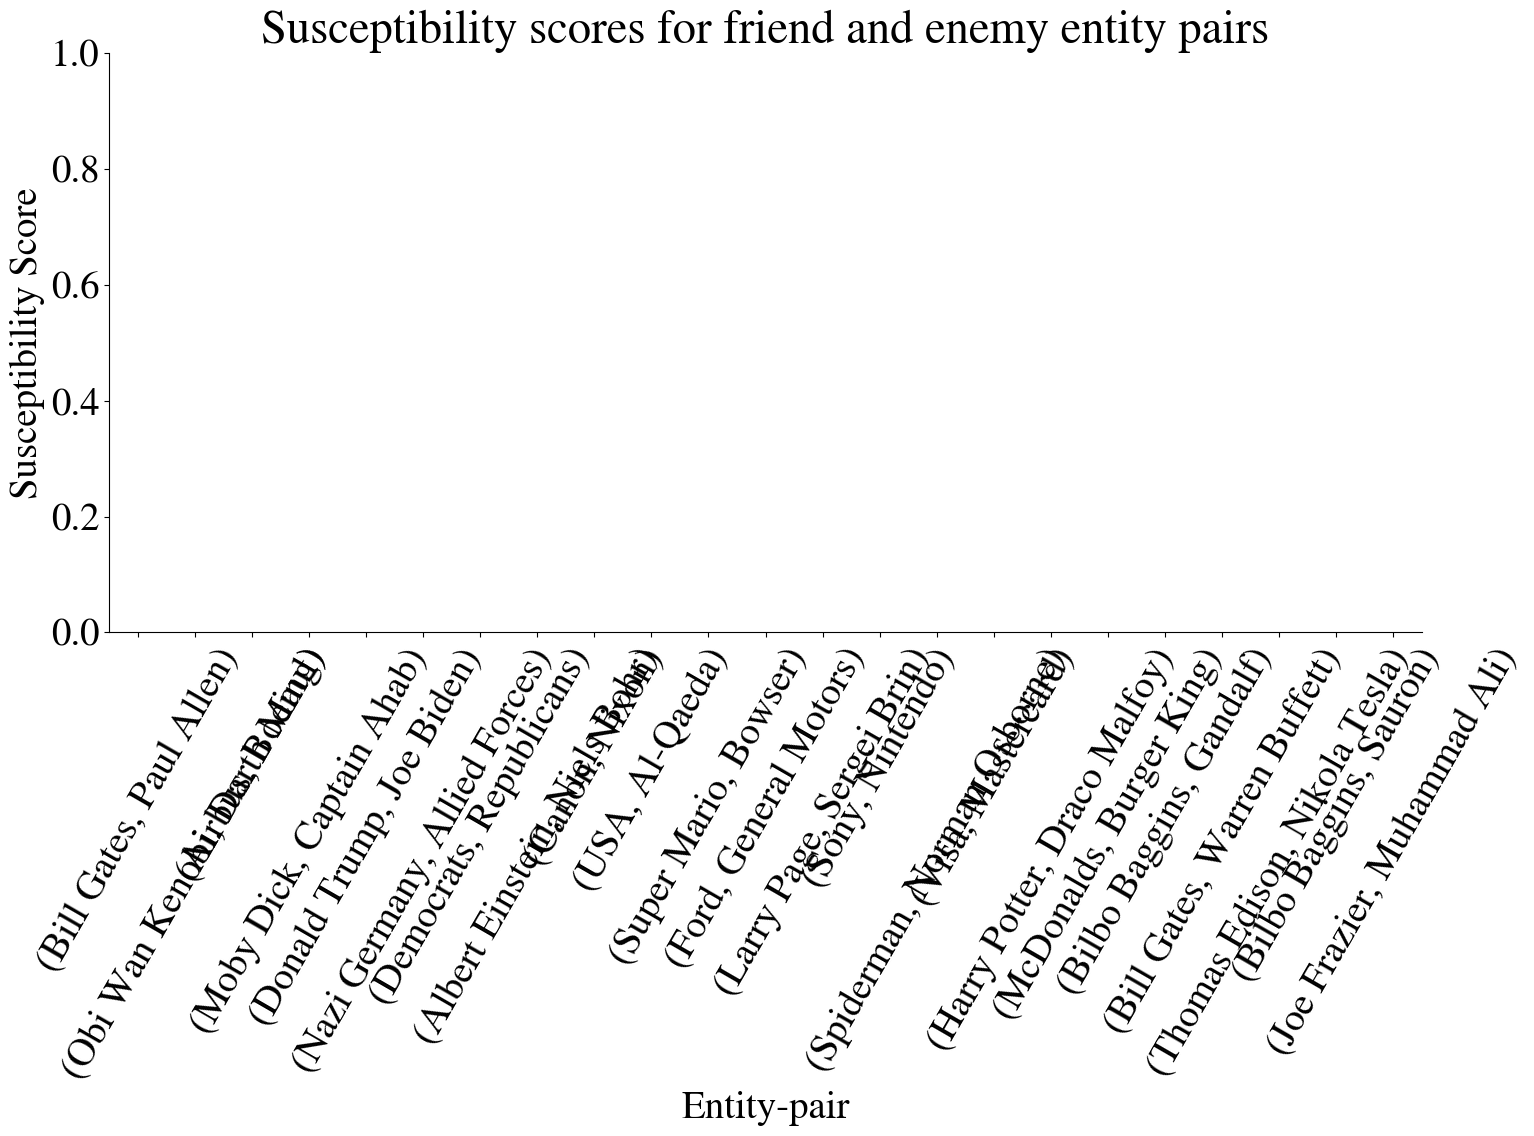

In [29]:
fig, ax = plt.subplots(figsize=(16, 12))
val_df_per_qe_sample = val_df_per_qe[val_df_per_qe["entity"].isin(entities.tolist())]
df = val_df_per_qe_sample[
    val_df_per_qe_sample["query_form"] == "The relationship between {} and {} is"
].sort_values(
    "susceptibility_score",
)
# print(df)
# print(
#     df.sort_values(["query_form", "susceptibility_score"])[
#         ["entity", "type", "label", "susceptibility_score"]
#     ]
# )
df["entity"] = df["entity"].apply(lambda x: "(" + ", ".join(x) + ")")
df["entity_len"] = df["entity"].apply(len)
df = df[df["entity_len"] < 30]
sns.stripplot(
    df,
    x="entity",
    y="susceptibility_score",
    hue="label",
    size=12,
    legend=None,
    ax=ax,
    palette=[colormap[e] for e in val_df_per_qe["label"].unique()],
)
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
ax.set_title(qf)
ax.set_title("Susceptibility scores for friend and enemy entity pairs")
ax.set_xlabel("Entity-pair")
ax.set_ylabel("Susceptibility Score")
plt.tight_layout()
plot_name = "plot_susscore_vs_friend_enemy"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

In [30]:
print(val_df_per_qe_sample["query_form"].unique())

['The relationship between {} and {} is'
 'Q: On a scale of 1-5, where 1 indicates worst enemies and 5 indicates best friends, how friendly are {} and {}?\nA:'
 'On a scale of 1-5, where 1 indicates worst enemies and 5 indicates best friends, the friendliness level of {} and {} is'
 'Q: On a scale of 1-5, how friendly are {} and {}?\nA:'
 'On a scale of 1-5, the friendliness level of {} and {} is']


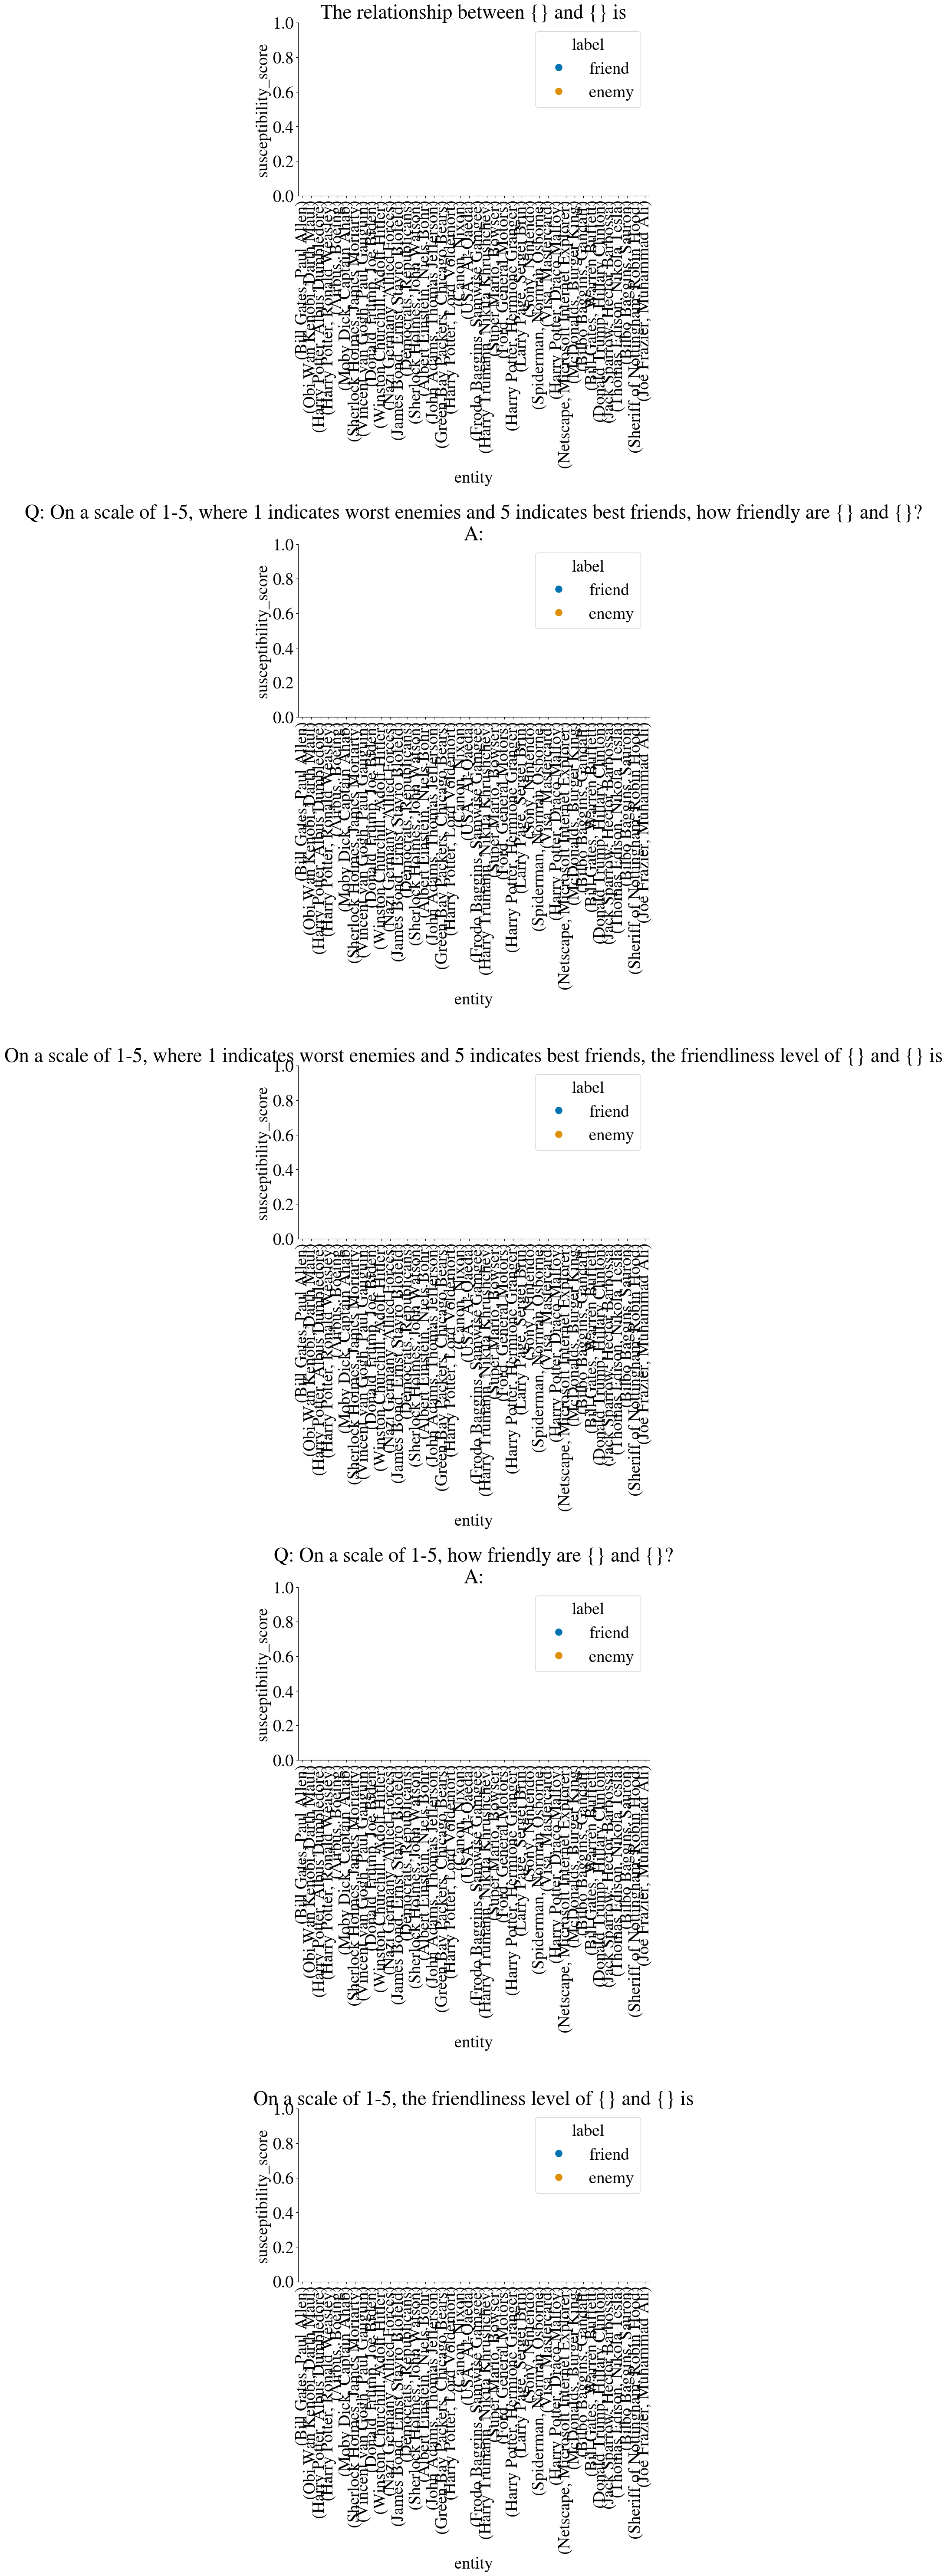

In [31]:
nrows = len(val_df_per_qe["query_form"].unique())
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(10, 12 * nrows))
val_df_per_qe_sample = val_df_per_qe[val_df_per_qe["entity"].isin(entities.tolist())]
for i, qf in enumerate(val_df_per_qe_sample["query_form"].unique()):
    ax = axes[i]
    df = val_df_per_qe_sample[val_df_per_qe_sample["query_form"] == qf].sort_values(
        "susceptibility_score",
    )
    # print(df)
    # print(
    #     df.sort_values(["query_form", "susceptibility_score"])[
    #         ["entity", "type", "label", "susceptibility_score"]
    #     ]
    # )
    df["entity"] = df["entity"].apply(lambda x: "(" + ", ".join(x) + ")")
    sns.stripplot(df, x="entity", y="susceptibility_score", hue="label", size=12, ax=ax)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.set_title(qf)
    plt.tight_layout()
    print("\n\n\n")

In [32]:
val_df_per_qe["query_form"].unique()

array(['The relationship between {} and {} is',
       'Q: On a scale of 1-5, where 1 indicates worst enemies and 5 indicates best friends, how friendly are {} and {}?\nA:',
       'On a scale of 1-5, where 1 indicates worst enemies and 5 indicates best friends, the friendliness level of {} and {} is',
       'Q: On a scale of 1-5, how friendly are {} and {}?\nA:',
       'On a scale of 1-5, the friendliness level of {} and {} is'],
      dtype=object)

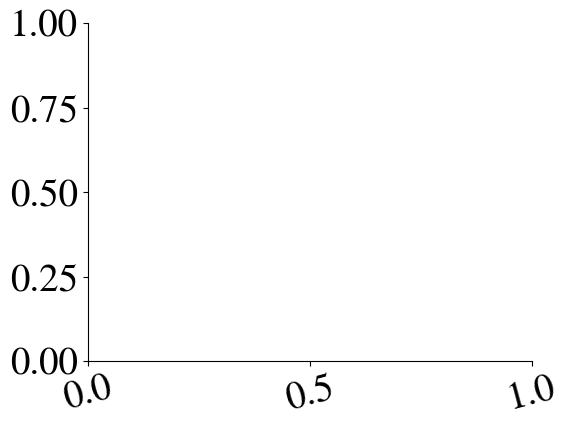

In [33]:
fig, ax = plt.subplots()
plot = sns.stripplot(
    data=val_df_per_qe[
        val_df_per_qe["query_form"] == "Q: Are {} and {} friends or enemies?\nA:"
    ],
    x="query_form",
    y="susceptibility_score",
    hue="label",
    ax=ax,
)
plt.tight_layout()
for tick in ax.get_xticklabels():
    tick.set_rotation(15)
plot_name = "plot_susscore_vs_queryform_friend_enemy"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

/scratch/tmp.52092879.kevidu/ipykernel_16776/2551121936.py:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


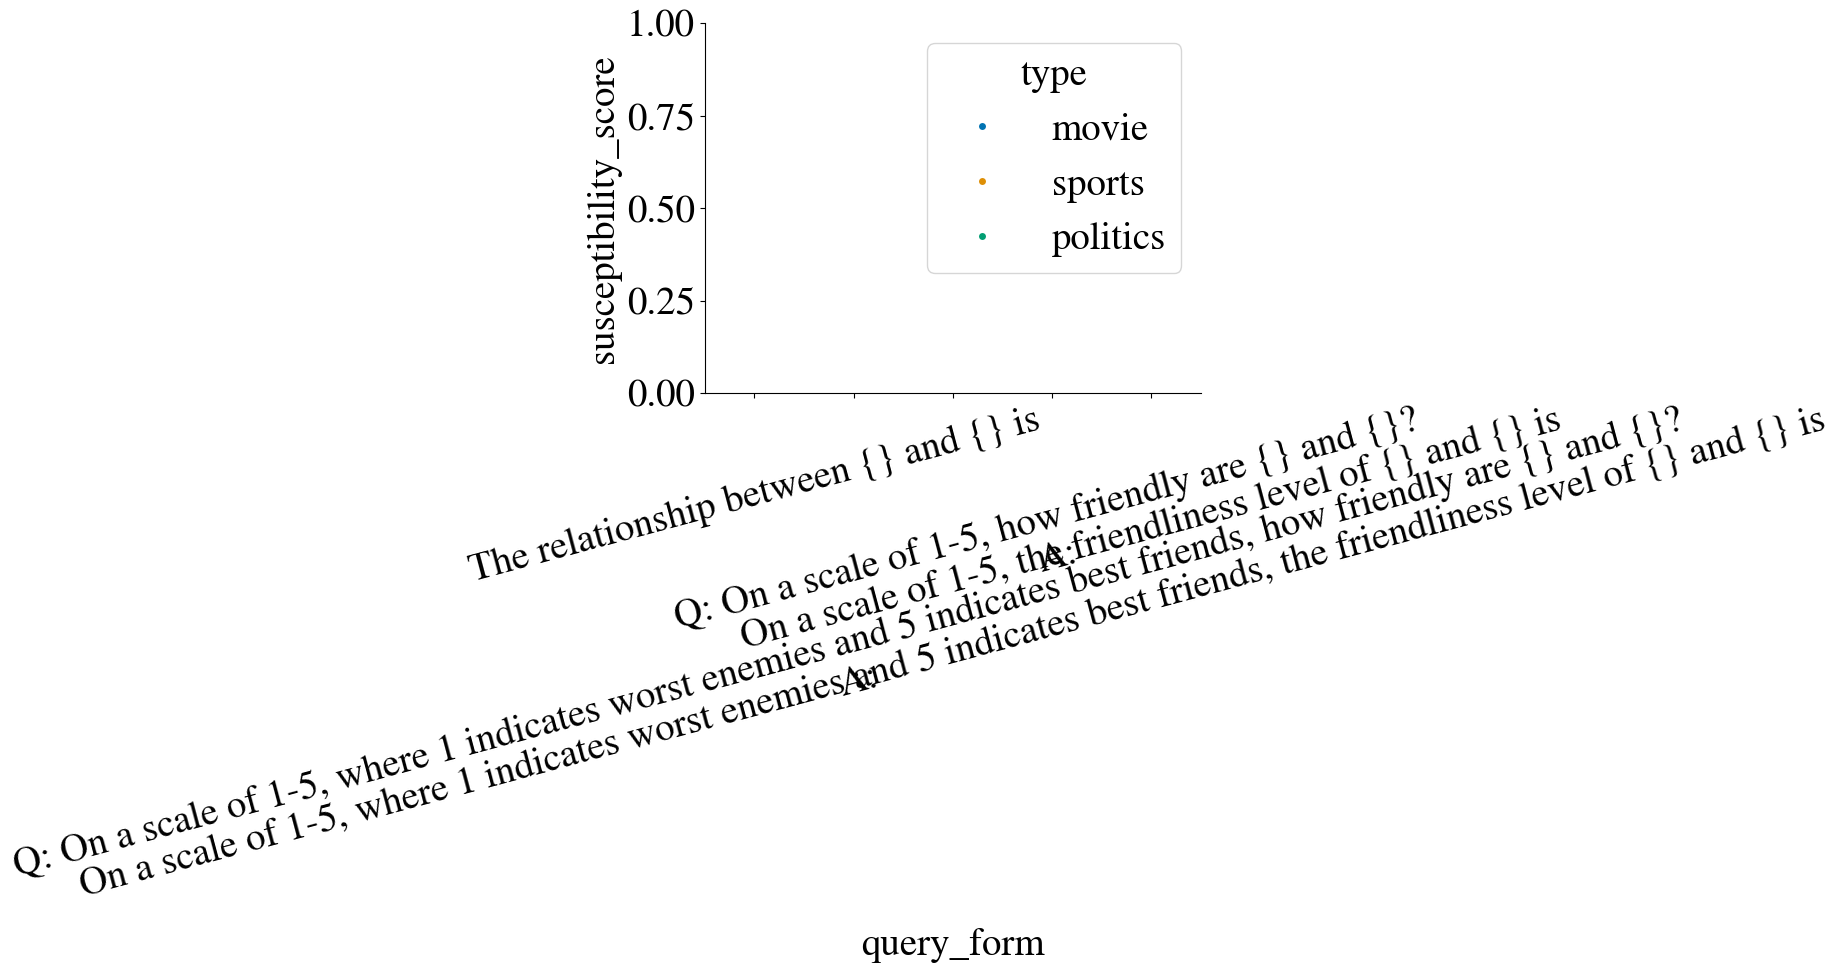

In [34]:
fig, ax = plt.subplots()
plot = sns.stripplot(
    data=val_df_per_qe[
        val_df_per_qe["type"].isin(
            [
                "sports",
                "politics",
                "movie",
            ]
        )
    ],
    x="query_form",
    y="susceptibility_score",
    hue="type",
    ax=ax,
    # hue="is_real",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)
plt.tight_layout()
for tick in ax.get_xticklabels():
    tick.set_rotation(15)
plot_name = "plot_susscore_vs_queryform_type"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

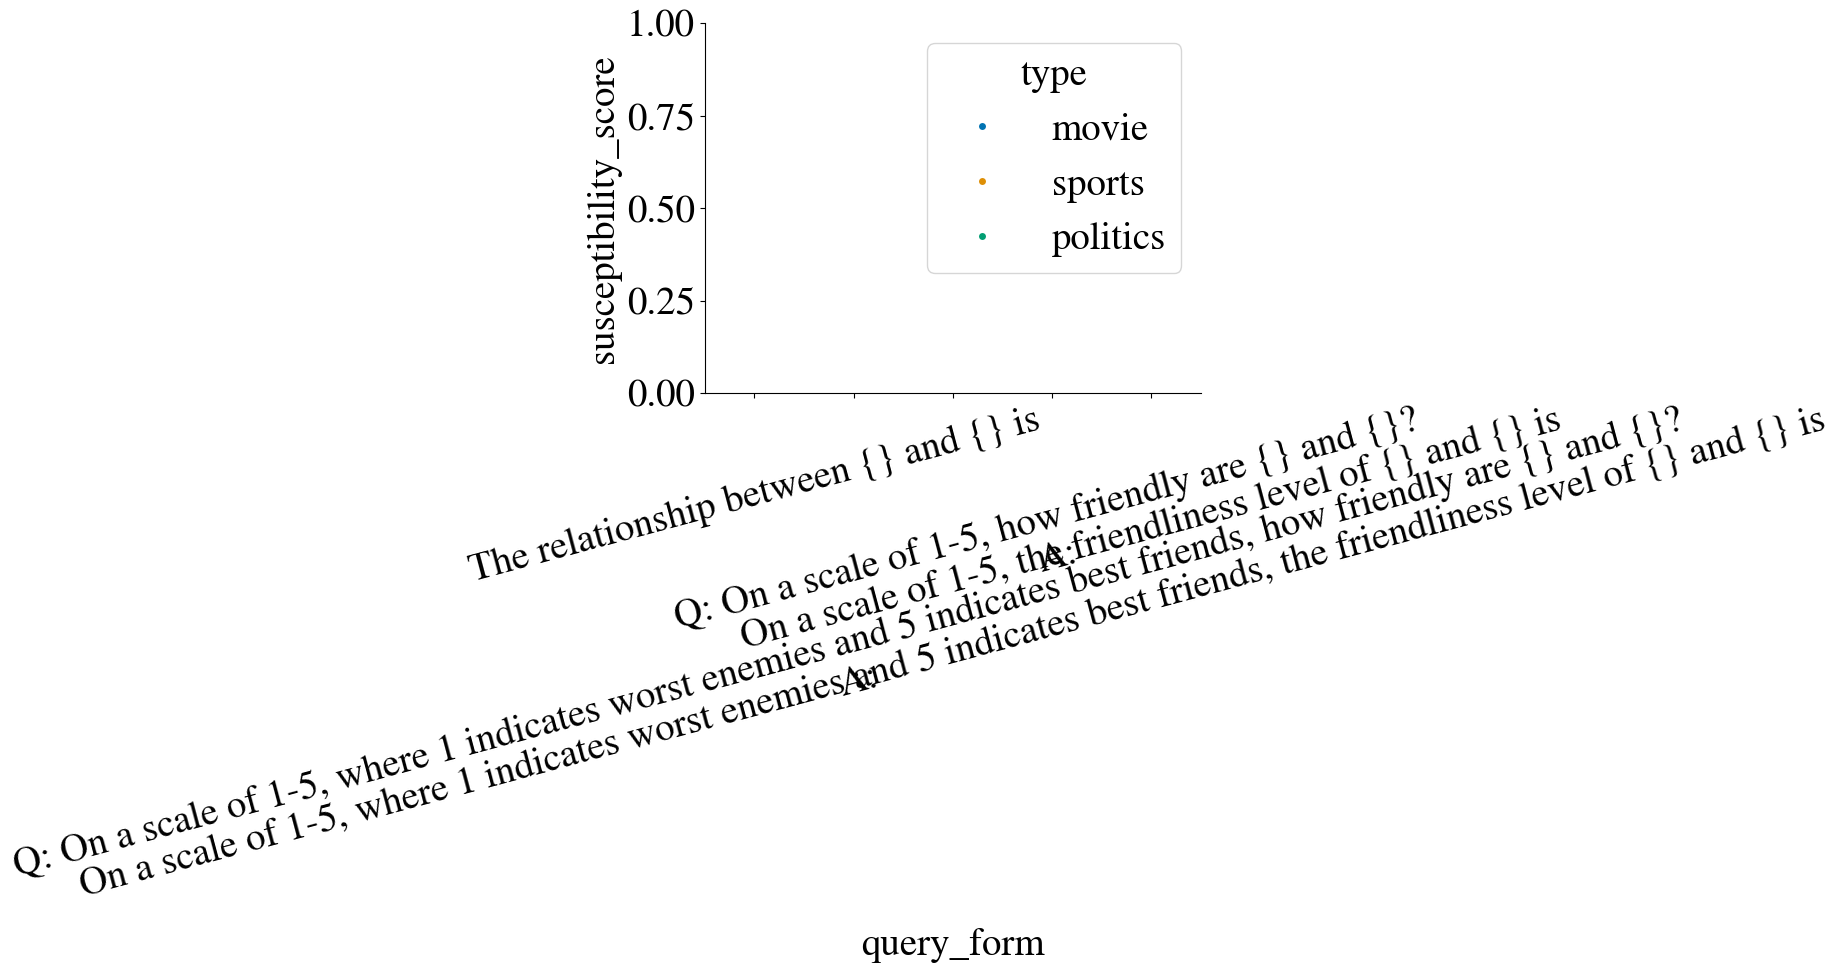

In [35]:
fig

### Exploring persuasion scores and sus scores

In [36]:
val_df_per_qe.sort_values(by="susceptibility_score").iloc[0]["contexts"]

['Super Mario adores Bowser.\n',
 'Superman sees Lex Luthor.\n',
 'Bilbo Baggins detests Sauron.\n',
 'Ford acknowledges General Motors.\n',
 'Joe Frazier hates Muhammad Ali.\n',
 'Bill Gates sees Paul Allen.\n',
 'Albert Einstein likes Niels Bohr.\n',
 'Gauls truly hates Rome.\n',
 'Winston Churchill meets Adolf Hitler.\n',
 'C.S. Lewis meets J.R.R. Tolkien.\n',
 'USA hates Al-Qaeda.\n',
 'C.S. Lewis sees J.R.R. Tolkien.\n',
 'Harry Potter likes Draco Malfoy.\n',
 'Frodo Baggins loves Samwise Gamgee.\n',
 'Woody meets Buzz Lightyear.\n',
 'Real Madrid hates FC Barcelona.\n',
 'UPS loves Fedex.\n',
 'John Adams meets Thomas Jefferson.\n',
 'Airbus acknowledges Boeing.\n',
 'Thomas Edison likes Henry Ford.\n',
 'Jack Sparrow meets Hector Barbossa.\n',
 'Thomas Edison acknowledges Nikola Tesla.\n',
 'Amelia Earhart truly hates Eleanor Roosevelt.\n',
 'Canon meets Nixon.\n',
 'Peter Pan hates Captain Hook.\n',
 'Harry Trumann dislikes Nikita Khrushchev.\n',
 'Sherlock Holmes detests John 

In [37]:
import re
from typing import Dict

context_types_dict = {
    "pos_trulyloves": "{entity} truly loves {entity}.\n",
    "pos_loves": "{entity} loves {entity}.\n",
    "pos_adores": "{entity} adores {entity}.\n",
    "pos_likes": "{entity} likes {entity}.\n",
    "neu_meets": "{entity} meets {entity}.\n",
    "neu_sees": "{entity} sees {entity}.\n",
    "neu_ack": "{entity} acknowledges {entity}.\n",
    "neg_trulyhates": "{entity} truly hates {entity}.\n",
    "neg_hates": "{entity} hates {entity}.\n",
    "neg_detests": "{entity} detests {entity}.\n",
    "neg_dislikes": "{entity} dislikes {entity}.\n",
}


def infer_context_type(context: str, context_types: Dict[str, str]):
    # Define the regex pattern to match "{entity} is the capital of {answer}."
    context_types_regexes = {
        f"^{v.replace('{entity}', '(.+)').replace('{answer}', '(.+)')}$": k
        for k, v in context_types.items()
    }
    # pattern = r"^(.+) is the capital of (.+)\.$"
    for regex, ct in context_types_regexes.items():
        match = re.match(regex, context)
        if match:
            e1, e2 = match.groups()
            return ct, (e1, e2)

    return None, None


infer_context_type(
    "Sarkozy truly loves Xi.\n",
    context_types_dict,
)

context_types, context_pairs = zip(
    *[
        infer_context_type(c, context_types_dict)
        for c in val_df_per_qe["contexts"].iloc[0]
    ]
)
val_df_per_qe["context_types"] = val_df_per_qe.apply(
    lambda x: context_types,
    axis=1,
)
val_df_per_qe["context_pairs"] = val_df_per_qe.apply(
    lambda x: context_pairs,
    axis=1,
)
val_df_per_qe

q_id                                         query_form  \
0    friend-enemy              The relationship between {} and {} is   
1    friend-enemy              The relationship between {} and {} is   
2    friend-enemy              The relationship between {} and {} is   
3    friend-enemy              The relationship between {} and {} is   
4    friend-enemy              The relationship between {} and {} is   
..            ...                                                ...   
360  friend-enemy  On a scale of 1-5, the friendliness level of {...   
361  friend-enemy  On a scale of 1-5, the friendliness level of {...   
362  friend-enemy  On a scale of 1-5, the friendliness level of {...   
363  friend-enemy  On a scale of 1-5, the friendliness level of {...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   

                                    entity      type  susceptibility_score  \
0                 (Bill Gates, Paul Allen)  business                   NaN   
1                 (Steve Jobs, Bill Gates)  business                   NaN   
2             (Obi Wan Kenobi, Darth Maul)     movie                   NaN   
3         (Harry Potter, Albus Dumbledore)     movie                   NaN   
4                            (Gauls, Rome)   history                   NaN   
..                                     ...       ...                   ...   
360                (Bilbo Baggins, Sauron)     movie                   NaN   
361    (Sheriff of Nottingham, Robin Hood)   history                   NaN   
362  (Kuomintang, Chinese Communist Party)   history                   NaN   
363            (Joe Frazier, Muhammad Ali)    sports                   NaN   
364                           (UPS, Fedex)  business                   NaN   

      label                                           contexts  \
0    friend  [Super Mario adores Bowser.\n, Superman sees L...   
1     enemy  [Super Mario adores Bowser.\n, Superman sees L...   
2     enemy  [Super Mario adores Bowser.\n, Superman sees L...   
3    friend  [Super Mario adores Bowser.\n, Superman sees L...   
4     enemy  [Super Mario adores Bowser.\n, Superman sees L...   
..      ...                                                ...   
360   enemy  [Super Mario adores Bowser.\n, Superman sees L...   
361   enemy  [Super Mario adores Bowser.\n, Superman sees L...   
362   enemy  [Super Mario adores Bowser.\n, Superman sees L...   
363   enemy  [Super Mario adores Bowser.\n, Superman sees L...   
364   enemy  [Super Mario adores Bowser.\n, Superman sees L...   

                                  persuasion_scores_kl  \
0    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
..                                                 ...   
360  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
361  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
362  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
363  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
364  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                         context_types  \
0    (pos_adores, neu_sees, neg_detests, neu_ack, n...   
1    (pos_adores, neu_sees, neg_detests, neu_ack, n...   
2    (pos_adores, neu_sees, neg_detests, neu_ack, n...   
3    (pos_adores, neu_sees, neg_detests, neu_ack, n...   
4    (pos_adores, neu_sees, neg_detests, neu_ack, n...   
..                                                 ...   
360  (pos_adores, neu_sees, neg_detests, neu_ack, n...   
361  (pos_adores, neu_sees, neg_detests, neu_ack, n...   
362  (pos_adores, neu_sees, neg_detests, neu_ack, n...   
363  (pos_adores, neu_sees, neg_detests, neu_ack, n...   
364  (pos_adores, neu_sees, neg_detests, neu_ack, n...   

                        

In [39]:
val_df_per_qe

q_id                                         query_form  \
0    friend-enemy              The relationship between {} and {} is   
1    friend-enemy              The relationship between {} and {} is   
2    friend-enemy              The relationship between {} and {} is   
3    friend-enemy              The relationship between {} and {} is   
4    friend-enemy              The relationship between {} and {} is   
..            ...                                                ...   
360  friend-enemy  On a scale of 1-5, the friendliness level of {...   
361  friend-enemy  On a scale of 1-5, the friendliness level of {...   
362  friend-enemy  On a scale of 1-5, the friendliness level of {...   
363  friend-enemy  On a scale of 1-5, the friendliness level of {...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   

                                    entity      type  susceptibility_score  \
0                 (Bill Gates, Paul Allen)  business                   NaN   
1                 (Steve Jobs, Bill Gates)  business                   NaN   
2             (Obi Wan Kenobi, Darth Maul)     movie                   NaN   
3         (Harry Potter, Albus Dumbledore)     movie                   NaN   
4                            (Gauls, Rome)   history                   NaN   
..                                     ...       ...                   ...   
360                (Bilbo Baggins, Sauron)     movie                   NaN   
361    (Sheriff of Nottingham, Robin Hood)   history                   NaN   
362  (Kuomintang, Chinese Communist Party)   history                   NaN   
363            (Joe Frazier, Muhammad Ali)    sports                   NaN   
364                           (UPS, Fedex)  business                   NaN   

      label                                           contexts  \
0    friend  [Super Mario adores Bowser.\n, Superman sees L...   
1     enemy  [Super Mario adores Bowser.\n, Superman sees L...   
2     enemy  [Super Mario adores Bowser.\n, Superman sees L...   
3    friend  [Super Mario adores Bowser.\n, Superman sees L...   
4     enemy  [Super Mario adores Bowser.\n, Superman sees L...   
..      ...                                                ...   
360   enemy  [Super Mario adores Bowser.\n, Superman sees L...   
361   enemy  [Super Mario adores Bowser.\n, Superman sees L...   
362   enemy  [Super Mario adores Bowser.\n, Superman sees L...   
363   enemy  [Super Mario adores Bowser.\n, Superman sees L...   
364   enemy  [Super Mario adores Bowser.\n, Superman sees L...   

                                  persuasion_scores_kl  \
0    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
..                                                 ...   
360  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
361  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
362  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
363  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
364  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                         context_types  \
0    (pos_adores, neu_sees, neg_detests, neu_ack, n...   
1    (pos_adores, neu_sees, neg_detests, neu_ack, n...   
2    (pos_adores, neu_sees, neg_detests, neu_ack, n...   
3    (pos_adores, neu_sees, neg_detests, neu_ack, n...   
4    (pos_adores, neu_sees, neg_detests, neu_ack, n...   
..                                                 ...   
360  (pos_adores, neu_sees, neg_detests, neu_ack, n...   
361  (pos_adores, neu_sees, neg_detests, neu_ack, n...   
362  (pos_adores, neu_sees, neg_detests, neu_ack, n...   
363  (pos_adores, neu_sees, neg_detests, neu_ack, n...   
364  (pos_adores, neu_sees, neg_detests, neu_ack, n...   

                        

In [38]:
exploded_df = explode_val_df_per_qe(
    val_df_per_qe,
    columns=["contexts", "persuasion_scores_kl", "context_types", "context_pairs"],
)

ValueError: malformed node or string on line 1: <ast.Name object at 0x2b63709eefe0>

In [ ]:
exploded_df

q_id                                         query_form  \
0    friend-enemy              The relationship between {} and {} is   
0    friend-enemy              The relationship between {} and {} is   
0    friend-enemy              The relationship between {} and {} is   
0    friend-enemy              The relationship between {} and {} is   
0    friend-enemy              The relationship between {} and {} is   
..            ...                                                ...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   

                       entity      type  susceptibility_score   label  \
0    (Bill Gates, Paul Allen)  business              0.174088  friend   
0    (Bill Gates, Paul Allen)  business              0.174088  friend   
0    (Bill Gates, Paul Allen)  business              0.174088  friend   
0    (Bill Gates, Paul Allen)  business              0.174088  friend   
0    (Bill Gates, Paul Allen)  business              0.174088  friend   
..                        ...       ...                   ...     ...   
364              (UPS, Fedex)  business              0.295471   enemy   
364              (UPS, Fedex)  business              0.295471   enemy   
364              (UPS, Fedex)  business              0.295471   enemy   
364              (UPS, Fedex)  business              0.295471   enemy   
364              (UPS, Fedex)  business              0.295471   enemy   

                                             contexts  persuasion_scores_kl  \
0                        Super Mario adores Bowser.\n              0.064646   
0                         Superman sees Lex Luthor.\n              0.190425   
0                     Bilbo Baggins detests Sauron.\n              0.112765   
0                 Ford acknowledges General Motors.\n              0.183265   
0                   Joe Frazier hates Muhammad Ali.\n              0.167467   
..                                                ...                   ...   
364                Thomas Edison sees Nikola Tesla.\n              0.250426   
364                       Super Mario loves Bowser.\n              0.155942   
364      Borussia Dortmund adores FC Bayern Munich.\n              0.285334   
364                     Steve Jobs sees Bill Gates.\n              0.182072   
364  Amelia Earhart acknowledges Eleanor Roosevelt.\n              0.293926   

    context_types                          context_pairs  
0      pos_adores                  (Super Mario, Bowser)  
0        neu_sees                 (Superman, Lex Luthor)  
0     neg_detests                (Bilbo Baggins, Sauron)  
0         neu_ack                 (Ford, General Motors)  
0       neg_hates            (Joe Frazier, Muhammad Ali)  
..            ...                                    ...  
364      neu_sees          (Thomas Edison, Nikola Tesla)  
364     pos_loves                  (Super Mario, Bowser)  
364    pos_adores  (Borussia Dortmund, FC Bayern Munich)  
364      neu_sees               (Steve Jobs, Bill Gates)  
364       neu_ack    (Amelia Earhart, Eleanor Roosevelt)  

[293095 rows x 10 columns]

In [ ]:
relevant_df = exploded_df[exploded_df["entity"] == exploded_df["context_pairs"]]
# relevant_df.groupby("query_form")

q_id                                         query_form  \
0    friend-enemy              The relationship between {} and {} is   
0    friend-enemy              The relationship between {} and {} is   
0    friend-enemy              The relationship between {} and {} is   
0    friend-enemy              The relationship between {} and {} is   
0    friend-enemy              The relationship between {} and {} is   
..            ...                                                ...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   

                       entity      type  susceptibility_score   label  \
0    (Bill Gates, Paul Allen)  business              0.174088  friend   
0    (Bill Gates, Paul Allen)  business              0.174088  friend   
0    (Bill Gates, Paul Allen)  business              0.174088  friend   
0    (Bill Gates, Paul Allen)  business              0.174088  friend   
0    (Bill Gates, Paul Allen)  business              0.174088  friend   
..                        ...       ...                   ...     ...   
364              (UPS, Fedex)  business              0.295471   enemy   
364              (UPS, Fedex)  business              0.295471   enemy   
364              (UPS, Fedex)  business              0.295471   enemy   
364              (UPS, Fedex)  business              0.295471   enemy   
364              (UPS, Fedex)  business              0.295471   enemy   

                              contexts  persuasion_scores_kl   context_types  \
0        Bill Gates sees Paul Allen.\n              0.169594        neu_sees   
0    Bill Gates dislikes Paul Allen.\n              0.331408    neg_dislikes   
0       Bill Gates likes Paul Allen.\n              0.149863       pos_likes   
0       Bill Gates hates Paul Allen.\n              0.229542       neg_hates   
0       Bill Gates meets Paul Allen.\n              0.309779       neu_meets   
..                                 ...                   ...             ...   
364          UPS acknowledges Fedex.\n              0.279545         neu_ack   
364                UPS adores Fedex.\n              0.240796      pos_adores   
364           UPS truly loves Fedex.\n              0.542268  pos_trulyloves   
364           UPS truly hates Fedex.\n              0.236780  neg_trulyhates   
364               UPS detests Fedex.\n              0.280234     neg_detests   

                context_pairs  
0    (Bill Gates, Paul Allen)  
0    (Bill Gates, Paul Allen)  
0    (Bill Gates, Paul Allen)  
0    (Bill Gates, Paul Allen)  
0    (Bill Gates, Paul Allen)  
..                        ...  
364              (UPS, Fedex)  
364              (UPS, Fedex)  
364              (UPS, Fedex)  
364              (UPS, Fedex)  
364              (UPS, Fedex)  

[4015 rows x 10 columns]

In [ ]:
def get_min_max(row, col_name):
    min_row = row[row[col_name] == row[col_name].min()]
    max_row = row[row[col_name] == row[col_name].max()]
    return pd.concat([min_row, max_row])


# Group by A and B, then apply the function
result = (
    val_df_per_qe.groupby(["query_form"])
    .apply(lambda x: get_min_max(x, "susceptibility_score"))
    .reset_index(drop=True)
)

# Display the result
result

/scratch/tmp.51946130.kevidu/ipykernel_85269/247749641.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: get_min_max(x, "susceptibility_score"))


q_id                                         query_form  \
0  friend-enemy  On a scale of 1-5, the friendliness level of {...   
1  friend-enemy  On a scale of 1-5, the friendliness level of {...   
2  friend-enemy  On a scale of 1-5, where 1 indicates worst ene...   
3  friend-enemy  On a scale of 1-5, where 1 indicates worst ene...   
4  friend-enemy  Q: On a scale of 1-5, how friendly are {} and ...   
5  friend-enemy  Q: On a scale of 1-5, how friendly are {} and ...   
6  friend-enemy  Q: On a scale of 1-5, where 1 indicates worst ...   
7  friend-enemy  Q: On a scale of 1-5, where 1 indicates worst ...   
8  friend-enemy              The relationship between {} and {} is   
9  friend-enemy              The relationship between {} and {} is   

                                       entity      type  susceptibility_score  \
0                         (USA, Soviet Union)   history              0.219335   
1                (Obi Wan Kenobi, Darth Maul)     movie              0.481498   
2                   (Larry Page, Sergei Brin)  business              0.071914   
3                (Obi Wan Kenobi, Darth Maul)     movie              0.211894   
4                       (Han Solo, Chewbacca)     movie              0.035702   
5  (Bal Gangadhar Tilak, Mohammed Ali Jinnah)   history              0.098761   
6                       (Han Solo, Chewbacca)     movie              0.033819   
7                          (Visa, Mastercard)  business              0.098256   
8                 (Real Madrid, FC Barcelona)    sports              0.091530   
9          (Harry Trumann, Nikita Khrushchev)   history              0.289432   

    label                                           contexts  \
0   enemy  [Super Mario adores Bowser.\n, Superman sees L...   
1   enemy  [Super Mario adores Bowser.\n, Superman sees L...   
2  friend  [Super Mario adores Bowser.\n, Superman sees L...   
3   enemy  [Super Mario adores Bowser.\n, Superman sees L...   
4  friend  [Super Mario adores Bowser.\n, Superman sees L...   
5  friend  [Super Mario adores Bowser.\n, Superman sees L...   
6  friend  [Super Mario adores Bowser.\n, Superman sees L...   
7   enemy  [Super Mario adores Bowser.\n, Superman sees L...   
8   enemy  [Super Mario adores Bowser.\n, Superman sees L...   
9   enemy  [Super Mario adores Bowser.\n, Superman sees L...   

                                persuasion_scores_kl  \
0  [0.09967044151501842, 0.2597295071991739, 0.31...   
1  [0.30039401247815295, 0.3588111056207672, 0.32...   
2  [0.039419614511744, 0.16373315588829648, 0.035...   
3  [0.17871579310391436, 0.38410804069092613, 0.0...   
4  [0.035208439423869316, 0.037601000179495074, 0...   
5  [0.080054034610473, 0.09397628188381756, 0.036...   
6  [0.08278693935991437, 0.03516453153169078, 0.0...   
7  [0.12098048716573832, 0.10792430232437969, 0.0...   
8  [0.031580733876632856, 0.09229897072732292, 0....   
9  [0.08169607092412286, 0.7598044676048422, 0.28...   

                                       context_types  \
0  (pos_adores, neu_sees, neg_detests, neu_ack, n...   
1  (pos_adores, neu_sees, neg_detests, neu_ack, n...   
2  (pos_adores, neu_sees, neg_detests, neu_ack, n...   
3  (pos_adores, neu_sees, neg_detests, neu_ack, n...   
4  (pos_adores, neu_sees, neg_detests, neu_ack, n...   
5  (pos_adores, neu_sees, neg_detests, neu_ack, n...   
6  (pos_adores, neu_sees, neg_detests, neu_ack, n...   
7  (pos_adores, neu_sees, neg_detests, neu_ack, n...   
8  (pos_adores, neu_sees, neg_detests, neu_ack, n...   
9  (pos_adores, neu_sees, neg_detests, neu_ack, n...   

                                       context_pairs  
0  ((Super Mario, Bowser), (Superman, Lex Luthor)...  
1  ((Super Mario, Bowser), (Superman, Lex Luthor)...  
2  ((Super Mario, Bowser), (Superman, Lex Luthor)...  
3  ((Super Mario, Bowser), (Superman, Lex Luthor)...  
4  ((Super Mario, Bowser), (Superman, Lex Luthor)...  
5  ((Super Mario, Bowser), (Superman, Lex Luthor)...  
6  ((Super Mario, Bowser

In [ ]:
print(result["query_form"].unique())

['On a scale of 1-5, the friendliness level of {} and {} is'
 'On a scale of 1-5, where 1 indicates worst enemies and 5 indicates best friends, the friendliness level of {} and {} is'
 'Q: On a scale of 1-5, how friendly are {} and {}?\nA:'
 'Q: On a scale of 1-5, where 1 indicates worst enemies and 5 indicates best friends, how friendly are {} and {}?\nA:'
 'The relationship between {} and {} is']


In [ ]:
exploded_min_max_df = explode_val_df_per_qe(
    result,
    columns=["contexts", "persuasion_scores_kl", "context_types", "context_pairs"],
)
exploded_min_max_df

q_id                                         query_form  \
0   friend-enemy  On a scale of 1-5, the friendliness level of {...   
0   friend-enemy  On a scale of 1-5, the friendliness level of {...   
0   friend-enemy  On a scale of 1-5, the friendliness level of {...   
0   friend-enemy  On a scale of 1-5, the friendliness level of {...   
0   friend-enemy  On a scale of 1-5, the friendliness level of {...   
..           ...                                                ...   
9   friend-enemy              The relationship between {} and {} is   
9   friend-enemy              The relationship between {} and {} is   
9   friend-enemy              The relationship between {} and {} is   
9   friend-enemy              The relationship between {} and {} is   
9   friend-enemy              The relationship between {} and {} is   

                                entity     type  susceptibility_score  label  \
0                  (USA, Soviet Union)  history              0.219335  enemy   
0                  (USA, Soviet Union)  history              0.219335  enemy   
0                  (USA, Soviet Union)  history              0.219335  enemy   
0                  (USA, Soviet Union)  history              0.219335  enemy   
0                  (USA, Soviet Union)  history              0.219335  enemy   
..                                 ...      ...                   ...    ...   
9   (Harry Trumann, Nikita Khrushchev)  history              0.289432  enemy   
9   (Harry Trumann, Nikita Khrushchev)  history              0.289432  enemy   
9   (Harry Trumann, Nikita Khrushchev)  history              0.289432  enemy   
9   (Harry Trumann, Nikita Khrushchev)  history              0.289432  enemy   
9   (Harry Trumann, Nikita Khrushchev)  history              0.289432  enemy   

                                            contexts  persuasion_scores_kl  \
0                       Super Mario adores Bowser.\n              0.099670   
0                        Superman sees Lex Luthor.\n              0.259730   
0                    Bilbo Baggins detests Sauron.\n              0.313514   
0                Ford acknowledges General Motors.\n              0.172145   
0                  Joe Frazier hates Muhammad Ali.\n              0.215039   
..                                               ...                   ...   
9                 Thomas Edison sees Nikola Tesla.\n              0.976888   
9                        Super Mario loves Bowser.\n              0.101614   
9       Borussia Dortmund adores FC Bayern Munich.\n              0.256155   
9                      Steve Jobs sees Bill Gates.\n              0.570528   
9   Amelia Earhart acknowledges Eleanor Roosevelt.\n              0.995942   

   context_types                          context_pairs  
0     pos_adores                  (Super Mario, Bowser)  
0       neu_sees                 (Superman, Lex Luthor)  
0    neg_detests                (Bilbo Baggins, Sauron)  
0        neu_ack                 (Ford, General Motors)  
0      neg_hates            (Joe Frazier, Muhammad Ali)  
..           ...                                    ...  
9       neu_sees          (Thomas Edison, Nikola Tesla)  
9      pos_loves                  (Super Mario, Bowser)  
9     pos_adores  (Borussia Dortmund, FC Bayern Munich)  
9       neu_sees               (Steve Jobs, Bill Gates)  
9        neu_ack    (Amelia Earhart, Eleanor Roosevelt)  

[8030 rows x 10 columns]

In [ ]:
exploded_min_max_df_ctxs = (
    exploded_min_max_df.groupby(["query_form", "entity"])
    .apply(lambda x: get_min_max(x, "persuasion_scores_kl"))
    .reset_index(drop=True)
)
exploded_min_max_df_ctxs

/scratch/tmp.51946130.kevidu/ipykernel_85269/2501028362.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: get_min_max(x, "persuasion_scores_kl"))


q_id                                         query_form  \
0   friend-enemy  On a scale of 1-5, the friendliness level of {...   
1   friend-enemy  On a scale of 1-5, the friendliness level of {...   
2   friend-enemy  On a scale of 1-5, the friendliness level of {...   
3   friend-enemy  On a scale of 1-5, the friendliness level of {...   
4   friend-enemy  On a scale of 1-5, where 1 indicates worst ene...   
5   friend-enemy  On a scale of 1-5, where 1 indicates worst ene...   
6   friend-enemy  On a scale of 1-5, where 1 indicates worst ene...   
7   friend-enemy  On a scale of 1-5, where 1 indicates worst ene...   
8   friend-enemy  Q: On a scale of 1-5, how friendly are {} and ...   
9   friend-enemy  Q: On a scale of 1-5, how friendly are {} and ...   
10  friend-enemy  Q: On a scale of 1-5, how friendly are {} and ...   
11  friend-enemy  Q: On a scale of 1-5, how friendly are {} and ...   
12  friend-enemy  Q: On a scale of 1-5, where 1 indicates worst ...   
13  friend-enemy  Q: On a scale of 1-5, where 1 indicates worst ...   
14  friend-enemy  Q: On a scale of 1-5, where 1 indicates worst ...   
15  friend-enemy  Q: On a scale of 1-5, where 1 indicates worst ...   
16  friend-enemy              The relationship between {} and {} is   
17  friend-enemy              The relationship between {} and {} is   
18  friend-enemy              The relationship between {} and {} is   
19  friend-enemy              The relationship between {} and {} is   

                                        entity      type  \
0                 (Obi Wan Kenobi, Darth Maul)     movie   
1                 (Obi Wan Kenobi, Darth Maul)     movie   
2                          (USA, Soviet Union)   history   
3                          (USA, Soviet Union)   history   
4                    (Larry Page, Sergei Brin)  business   
5                    (Larry Page, Sergei Brin)  business   
6                 (Obi Wan Kenobi, Darth Maul)     movie   
7                 (Obi Wan Kenobi, Darth Maul)     movie   
8   (Bal Gangadhar Tilak, Mohammed Ali Jinnah)   history   
9   (Bal Gangadhar Tilak, Mohammed Ali Jinnah)   history   
10                       (Han Solo, Chewbacca)     movie   
11                       (Han Solo, Chewbacca)     movie   
12                       (Han Solo, Chewbacca)     movie   
13                       (Han Solo, Chewbacca)     movie   
14                          (Visa, Mastercard)  business   
15                          (Visa, Mastercard)  business   
16          (Harry Trumann, Nikita Khrushchev)   history   
17          (Harry Trumann, Nikita Khrushchev)   history   
18                 (Real Madrid, FC Barcelona)    sports   
19                 (Real Madrid, FC Barcelona)    sports   

    susceptibility_score   label  \
0               0.481498   enemy   
1               0.481498   enemy   
2               0.219335   enemy   
3               0.219335   enemy   
4               0.071914  friend   
5               0.071914  friend   
6               0.211894   enemy   
7               0.211894   enemy   
8               0.098761  friend   
9               0.098761  friend   
10              0.035702  friend   
11              0.035702  friend   
12              0.033819  friend   
13              0.033819  friend   
14              0.098256   enemy   
15              0.098256   enemy   
16              0.289432   enemy   
17              0.289432   enemy   
18              0.091530   enemy   
19              0.091530   enemy   

                                             contexts  persuasion_scores_kl  \
0                   Spiderman loves Norman Osborne.\n              0.077647   
1                 Obi Wan Kenobi adores Darth Maul.\n              1.994114   
2             Spiderman truly loves Norman Osborne.\n              0.046821   
3                      Moby Dick sees Captain Ahab.\n              2.019441   
4                         Han Solo meets Chewbacca.\n              0.013172   
5               Larry Page t

In [ ]:
# Find the effect of positive contexts on susceptibility
def add_ctx_dir_and_strength(df):
    map_relation_to_strength = {
        "trulyloves": 4,
        "loves": 3,
        "adores": 2,
        "likes": 1,
        "meets": 0,
        "sees": 0,
        "ack": 0,
        "dislikes": 1,
        "detests": 2,
        "hates": 3,
        "trulyhates": 4,
    }

    df["ctx_dir"] = df["context_types"].apply(lambda x: x.split("_")[0])
    df["ctx_strength"] = df["context_types"].apply(
        lambda x: map_relation_to_strength[x.split("_")[1]]
    )
    return df


exploded_min_max_df_ctxs = add_ctx_dir_and_strength(exploded_min_max_df_ctxs)
exploded_df = add_ctx_dir_and_strength(exploded_df)

In [ ]:
qfs = exploded_min_max_df["query_form"].unique()
df0 = exploded_min_max_df[exploded_min_max_df["query_form"] == qfs[0]]
df0

q_id                                         query_form  \
0   friend-enemy  On a scale of 1-5, the friendliness level of {...   
0   friend-enemy  On a scale of 1-5, the friendliness level of {...   
0   friend-enemy  On a scale of 1-5, the friendliness level of {...   
0   friend-enemy  On a scale of 1-5, the friendliness level of {...   
0   friend-enemy  On a scale of 1-5, the friendliness level of {...   
..           ...                                                ...   
1   friend-enemy  On a scale of 1-5, the friendliness level of {...   
1   friend-enemy  On a scale of 1-5, the friendliness level of {...   
1   friend-enemy  On a scale of 1-5, the friendliness level of {...   
1   friend-enemy  On a scale of 1-5, the friendliness level of {...   
1   friend-enemy  On a scale of 1-5, the friendliness level of {...   

                          entity     type  susceptibility_score  label  \
0            (USA, Soviet Union)  history              0.219335  enemy   
0            (USA, Soviet Union)  history              0.219335  enemy   
0            (USA, Soviet Union)  history              0.219335  enemy   
0            (USA, Soviet Union)  history              0.219335  enemy   
0            (USA, Soviet Union)  history              0.219335  enemy   
..                           ...      ...                   ...    ...   
1   (Obi Wan Kenobi, Darth Maul)    movie              0.481498  enemy   
1   (Obi Wan Kenobi, Darth Maul)    movie              0.481498  enemy   
1   (Obi Wan Kenobi, Darth Maul)    movie              0.481498  enemy   
1   (Obi Wan Kenobi, Darth Maul)    movie              0.481498  enemy   
1   (Obi Wan Kenobi, Darth Maul)    movie              0.481498  enemy   

                                            contexts  persuasion_scores_kl  \
0                       Super Mario adores Bowser.\n              0.099670   
0                        Superman sees Lex Luthor.\n              0.259730   
0                    Bilbo Baggins detests Sauron.\n              0.313514   
0                Ford acknowledges General Motors.\n              0.172145   
0                  Joe Frazier hates Muhammad Ali.\n              0.215039   
..                                               ...                   ...   
1                 Thomas Edison sees Nikola Tesla.\n              0.494328   
1                        Super Mario loves Bowser.\n              0.258999   
1       Borussia Dortmund adores FC Bayern Munich.\n              0.335753   
1                      Steve Jobs sees Bill Gates.\n              0.250988   
1   Amelia Earhart acknowledges Eleanor Roosevelt.\n              0.631395   

   context_types                          context_pairs ctx_dir  ctx_strength  
0     pos_adores                  (Super Mario, Bowser)     pos             2  
0       neu_sees                 (Superman, Lex Luthor)     neu             0  
0    neg_detests                (Bilbo Baggins, Sauron)     neg             2  
0        neu_ack                 (Ford, General Motors)     neu             0  
0      neg_hates            (Joe Frazier, Muhammad Ali)     neg             3  
..           ...                                    ...     ...           ...  
1       neu_sees          (Thomas Edison, Nikola Tesla)     neu             0  
1      pos_loves                  (Super Mario, Bowser)     pos             3  
1     pos_adores  (Borussia Dortmund, FC Bayern Munich)     pos             2  
1       neu_sees               (Steve Jobs, Bill Gates)     neu             0  
1        neu_ack    (Amelia Earhart, Eleanor Roosevelt)     neu             0  

[1606 rows x 12 columns]

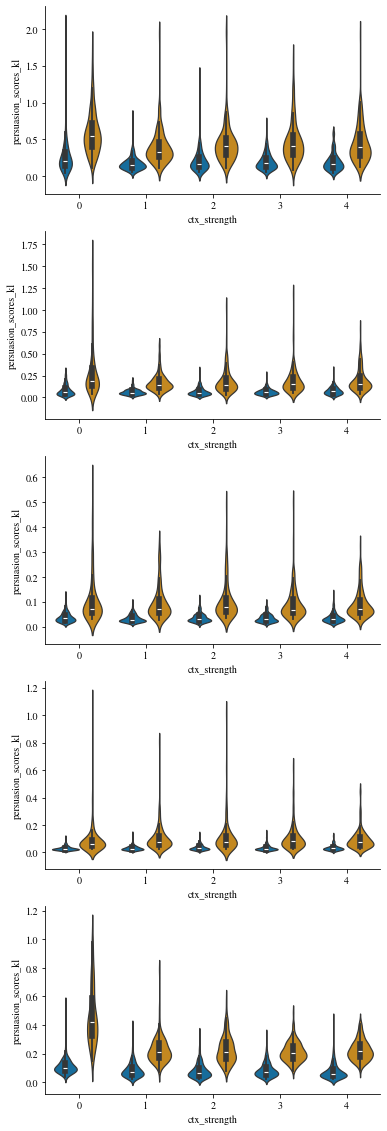

In [ ]:
df_grouped = exploded_min_max_df.groupby("query_form")
fig, axes = plt.subplots(len(df_grouped), 1, figsize=(6, 20))
for i, (name, df) in enumerate(df_grouped):
    ax = axes[i]
    sns.violinplot(
        data=df,
        x="ctx_strength",
        y="persuasion_scores_kl",
        hue="entity",
        ax=ax,
        legend=None,
    )

In [ ]:
relevant_df = exploded_df[exploded_df["entity"] == exploded_df["context_pairs"]]
relevant_df

q_id                                         query_form  \
0    friend-enemy              The relationship between {} and {} is   
0    friend-enemy              The relationship between {} and {} is   
0    friend-enemy              The relationship between {} and {} is   
0    friend-enemy              The relationship between {} and {} is   
0    friend-enemy              The relationship between {} and {} is   
..            ...                                                ...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   
364  friend-enemy  On a scale of 1-5, the friendliness level of {...   

                       entity      type  susceptibility_score   label  \
0    (Bill Gates, Paul Allen)  business              0.174088  friend   
0    (Bill Gates, Paul Allen)  business              0.174088  friend   
0    (Bill Gates, Paul Allen)  business              0.174088  friend   
0    (Bill Gates, Paul Allen)  business              0.174088  friend   
0    (Bill Gates, Paul Allen)  business              0.174088  friend   
..                        ...       ...                   ...     ...   
364              (UPS, Fedex)  business              0.295471   enemy   
364              (UPS, Fedex)  business              0.295471   enemy   
364              (UPS, Fedex)  business              0.295471   enemy   
364              (UPS, Fedex)  business              0.295471   enemy   
364              (UPS, Fedex)  business              0.295471   enemy   

                              contexts  persuasion_scores_kl   context_types  \
0        Bill Gates sees Paul Allen.\n              0.169594        neu_sees   
0    Bill Gates dislikes Paul Allen.\n              0.331408    neg_dislikes   
0       Bill Gates likes Paul Allen.\n              0.149863       pos_likes   
0       Bill Gates hates Paul Allen.\n              0.229542       neg_hates   
0       Bill Gates meets Paul Allen.\n              0.309779       neu_meets   
..                                 ...                   ...             ...   
364          UPS acknowledges Fedex.\n              0.279545         neu_ack   
364                UPS adores Fedex.\n              0.240796      pos_adores   
364           UPS truly loves Fedex.\n              0.542268  pos_trulyloves   
364           UPS truly hates Fedex.\n              0.236780  neg_trulyhates   
364               UPS detests Fedex.\n              0.280234     neg_detests   

                context_pairs ctx_dir  ctx_strength  
0    (Bill Gates, Paul Allen)     neu             0  
0    (Bill Gates, Paul Allen)     neg             1  
0    (Bill Gates, Paul Allen)     pos             1  
0    (Bill Gates, Paul Allen)     neg             3  
0    (Bill Gates, Paul Allen)     neu             0  
..                        ...     ...           ...  
364              (UPS, Fedex)     neu             0  
364              (UPS, Fedex)     pos             2  
364              (UPS, Fedex)     pos             4  
364              (UPS, Fedex)     neg             4  
364              (UPS, Fedex)     neg             2  

[4015 rows x 12 columns]

In [ ]:
df

q_id                             query_form  \
0   friend-enemy  The relationship between {} and {} is   
0   friend-enemy  The relationship between {} and {} is   
0   friend-enemy  The relationship between {} and {} is   
0   friend-enemy  The relationship between {} and {} is   
0   friend-enemy  The relationship between {} and {} is   
..           ...                                    ...   
72  friend-enemy  The relationship between {} and {} is   
72  friend-enemy  The relationship between {} and {} is   
72  friend-enemy  The relationship between {} and {} is   
72  friend-enemy  The relationship between {} and {} is   
72  friend-enemy  The relationship between {} and {} is   

                      entity      type  susceptibility_score   label  \
0   (Bill Gates, Paul Allen)  business              0.174088  friend   
0   (Bill Gates, Paul Allen)  business              0.174088  friend   
0   (Bill Gates, Paul Allen)  business              0.174088  friend   
0   (Bill Gates, Paul Allen)  business              0.174088  friend   
0   (Bill Gates, Paul Allen)  business              0.174088  friend   
..                       ...       ...                   ...     ...   
72              (UPS, Fedex)  business              0.153747   enemy   
72              (UPS, Fedex)  business              0.153747   enemy   
72              (UPS, Fedex)  business              0.153747   enemy   
72              (UPS, Fedex)  business              0.153747   enemy   
72              (UPS, Fedex)  business              0.153747   enemy   

                             contexts  persuasion_scores_kl   context_types  \
0       Bill Gates sees Paul Allen.\n              0.169594        neu_sees   
0   Bill Gates dislikes Paul Allen.\n              0.331408    neg_dislikes   
0      Bill Gates likes Paul Allen.\n              0.149863       pos_likes   
0      Bill Gates hates Paul Allen.\n              0.229542       neg_hates   
0      Bill Gates meets Paul Allen.\n              0.309779       neu_meets   
..                                ...                   ...             ...   
72          UPS acknowledges Fedex.\n              0.327150         neu_ack   
72                UPS adores Fedex.\n              0.138077      pos_adores   
72           UPS truly loves Fedex.\n              0.458962  pos_trulyloves   
72           UPS truly hates Fedex.\n              0.228994  neg_trulyhates   
72               UPS detests Fedex.\n              0.293187     neg_detests   

               context_pairs ctx_dir  ctx_strength  
0   (Bill Gates, Paul Allen)     neu             0  
0   (Bill Gates, Paul Allen)     neg             1  
0   (Bill Gates, Paul Allen)     pos             1  
0   (Bill Gates, Paul Allen)     neg             3  
0   (Bill Gates, Paul Allen)     neu             0  
..                       ...     ...           ...  
72              (UPS, Fedex)     neu             0  
72              (UPS, Fedex)     pos             2  
72              (UPS, Fedex)     pos             4  
72              (UPS, Fedex)     neg             4  
72              (UPS, Fedex)     neg             2  

[803 rows x 12 columns]

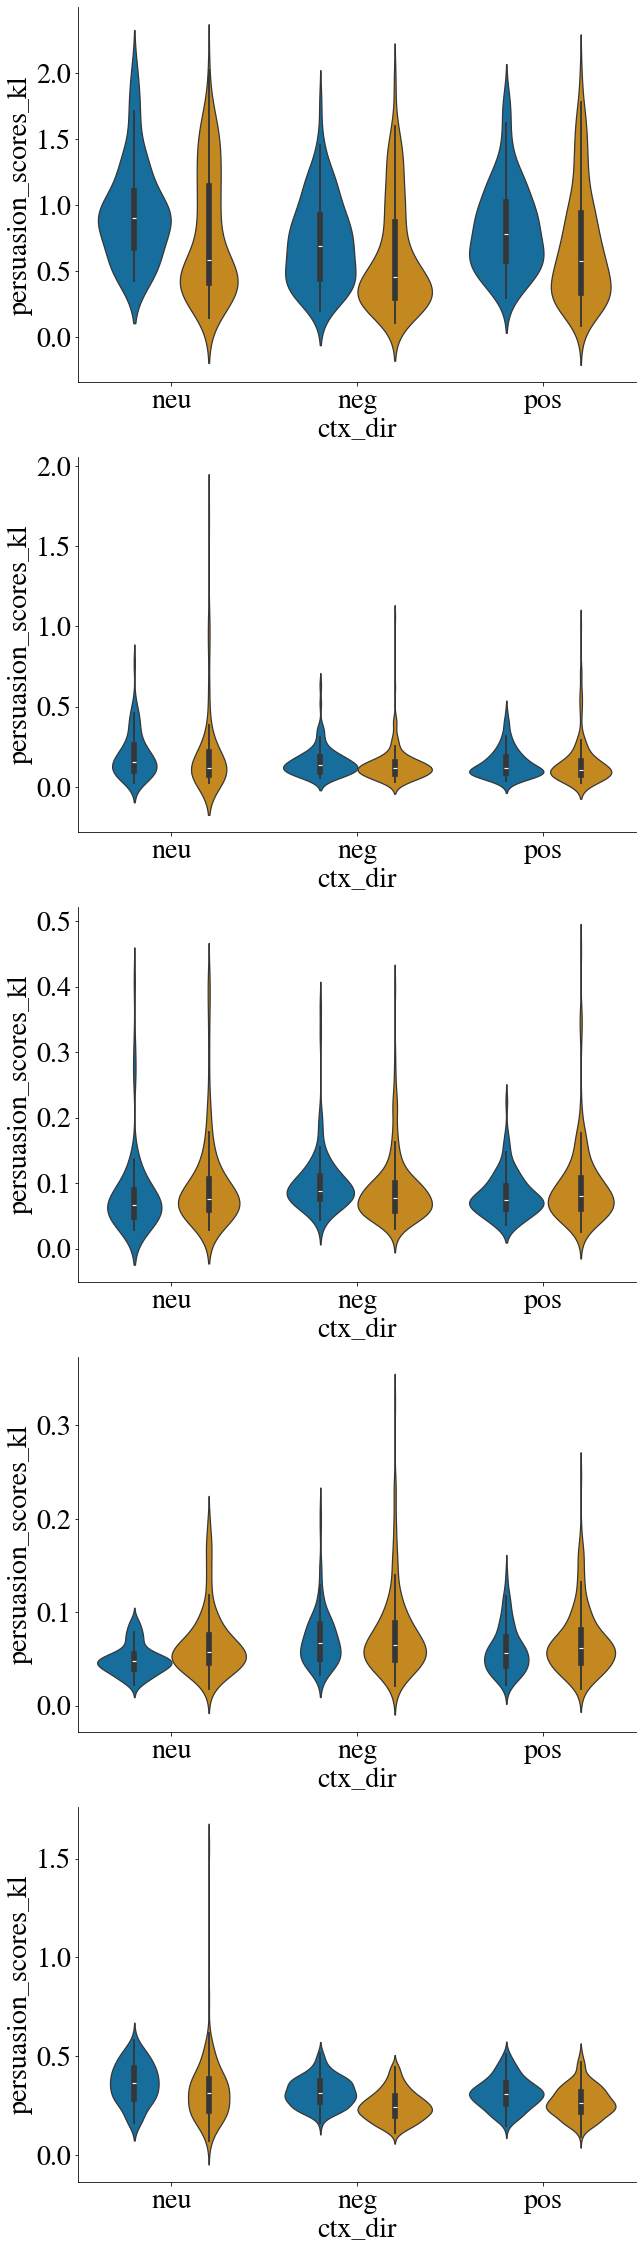

In [ ]:
relevant_df_grouped = relevant_df.groupby("query_form")
fig, axes = plt.subplots(len(df_grouped), 1, figsize=(10, 40))
for i, (name, df) in enumerate(relevant_df_grouped):
    ax = axes[i]
    sns.violinplot(
        data=df,
        x="ctx_dir",
        y="persuasion_scores_kl",
        hue="label",
        ax=ax,
        legend=None,
    )

In [ ]:
relevant_df = relevant_df.sort_values("susceptibility_score")
# relevant_df.groupby(["query_form"]).apply(
#     lambda x: x.sort_values(["susceptibility_score"])
# ).reset_index().groupby(["entity"]).apply(
#     lambda x: x.sort_values(["susceptibility_score", "persuasion_scores_kl"])
# ).drop(
#     columns=["q_id", "query_form", "entity"]
# )[
#     [
#         "ctx_dir",
#         "ctx_strength",
#         "context_types",
#         "persuasion_scores_kl",
#         "susceptibility_score",
#     ]
# ]

In [ ]:
sorted_relevant_df = (
    relevant_df.groupby(["query_form", "entity"])
    .apply(lambda x: x.sort_values(["susceptibility_score", "persuasion_scores_kl"]))
    .drop(columns=["q_id", "query_form", "entity"])[
        [
            "ctx_dir",
            "ctx_strength",
            "context_types",
            "persuasion_scores_kl",
            "susceptibility_score",
        ]
    ]
)

/scratch/tmp.51946130.kevidu/ipykernel_85269/537674674.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values(["susceptibility_score", "persuasion_scores_kl"]))


In [ ]:
i = 104
sorted_relevant_df.loc[sorted_relevant_df.index[11 * i]]

ctx_dir  \
query_form                                         entity                                         
On a scale of 1-5, where 1 indicates worst enem... (Harry Potter, Hermione Granger) 194     pos   
                                                                                    194     neg   
                                                                                    194     neg   
                                                                                    194     neu   
                                                                                    194     neg   
                                                                                    194     pos   
                                                                                    194     pos   
                                                                                    194     neg   
                                                                                    194     pos   
                                                                                    194     neu   
                                                                                    194     neu   

                                                                                         ctx_strength  \
query_form                                         entity                                               
On a scale of 1-5, where 1 indicates worst enem... (Harry Potter, Hermione Granger) 194             1   
                                                                                    194             4   
                                                                                    194             2   
                                                                                    194             0   
                                                                                    194             3   
                                                                                    194             2   
                                                                                    194             4   
                                                                                    194             1   
                                                                                    194             3   
                                                                                    194             0   
                                                                                    194             0   

                                                                                          context_types  \
query_form                                         entity                                                 
On a scale of 1-5, where 1 indicates worst enem... (Harry Potter, Hermione Granger) 194       pos_likes   
                                                                                    194  neg_trulyhates   
                                                                                    194     neg_detests   
                                                                                    194         neu_ack   
                                                                                    194       neg_hates   
                                                                                    194      pos_adores   
                                                                                    194  pos_trulyloves   
                                                                                    194    neg_dislikes   
                                                                                    194       pos_loves   
                                                                                    194       neu_meets   
                                                                                    194        neu_sees   

                                          

In [ ]:
wandb.finish()